<font size = 6> Предсказание цен на недвижимость

Выполнил:
Шавалюк Степан Васильевич

# Введение

Импортируем нужные нам библиотеки

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.1 MB/s eta 0:00:00


In [ ]:

import pandas as pd
import numpy as np
import os
import graphviz


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor




from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor, Pool
from catboost import CatBoostRegressor, Pool, cv
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import MinMaxScaler



#from sklearn.model_selection import train_test_split, GridSearchCV
 # from sklearn.preprocessing import MinMaxScaler, LabelEncoder
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Dropout
#from tensorflow.keras.callbacks import EarlyStopping
#from keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import csv



In [ ]:
def metric(model, X, y):


    metric_res = []
    mape = make_scorer(mean_absolute_percentage_error)
    mae = make_scorer(mean_absolute_error)
    mse = make_scorer(mean_squared_error)


    mape_cv = cross_val_score(model, X, y, cv = 3, scoring = mape)
    mae_cv = cross_val_score(model, X, y, cv = 3, scoring = mae)
    mse_cv = cross_val_score(model, X, y, cv = 3, scoring = mse)


    metric_res.append(mape_cv)
    metric_res.append(mae_cv)
    metric_res.append(mse_cv)



    return metric_res

Загрузим данные

In [ ]:
df = pd.read_csv('ds_clear.csv')

Посмотрим информацию о признаках



In [ ]:
info = pd.DataFrame()
info.index = df.columns
info['Тип данных'] = df.dtypes
info['Колчесвто уникальных'] = df.nunique()
info['Количество пропусков'] = df.isna().sum()
info['Количество значений'] = df.count()
info['%значений'] = round((df.count()/ df.shape[0]) * 100,2)
info

,Тип данных,Колчесвто уникальных,Количество пропусков,Количество значений,%значений
Цена,float64,9979,0,22676,100.0
Тип квартиры,object,2,0,22676,100.0
Станция метро,object,547,0,22676,100.0
Минут до метро,float64,56,0,22676,100.0
Регион,object,2,0,22676,100.0
Адрес,object,6386,0,22676,100.0
Количество комнат,float64,12,0,22676,100.0
Площадь,float64,3017,0,22676,100.0
Жилая площадь,float64,1302,0,22676,100.0
Кухня площадь,float64,481,0,22676,100.0


**Проанализировав таблицу можно сделать выводы о наборе данных:**


1.  В каждом признаке 0 пропущенных значений
2. Признак `Цена`:есть цены на квартиры, которые повторяются( можно сделать простой вывод, что есть цены на квартиры, которые повторяются)


### Убираем пробелы и дубликаты

In [ ]:
df['Станция метро'] = df['Станция метро'].str.lower().str.strip()

In [ ]:
#количество уникальных значений в столбце
df['Станция метро'].nunique()

310

In [ ]:
df = df.drop_duplicates(subset="Ссылка")
print(df.shape)


(21813, 14)



Новые значения сохраним с основной набор

### Просмотр статистики

In [ ]:
describe = df.describe().T
describe['mean'] = describe['mean'].apply(lambda x: '{:.2f}'.format(x))
describe['std'] = describe['std'].apply(lambda x: '{:.2f}'.format(x))
describe['max'] = describe['max'].apply(lambda x: '{:.2f}'.format(x))
describe['count'] =describe['count'].astype('int')
describe

,count,mean,std,min,25%,50%,75%,max
Цена,21813,32878966.67,77996296.24,1150000.0,6998445.00,11086692.0,22383687.00,2455020000.00
Минут до метро,21813,11.98,6.21,0.0,7.00,12.0,15.00,60.00
Количество комнат,21813,2.01,1.47,0.0,1.00,2.0,3.00,12.00
Площадь,21813,68.76,62.99,6.0,37.16,52.4,74.65,1117.00
Жилая площадь,21813,37.00,35.31,2.0,17.50,28.1,42.00,566.80
Кухня площадь,21813,12.34,7.39,1.0,8.60,10.5,14.00,122.00
Этаж,21813,9.17,7.40,1.0,4.00,8.0,13.00,92.00
Количество этажей,21813,16.51,9.42,1.0,11.00,16.0,20.00,97.00




**Выводы:**
1. Среднее значение цены  32.000.000
2. Минимальная цена 1.000.000
3. Максимальная цена дома 2.000.000.000
4. Между 50% и максимальным значением,присуствует большой разрыв,что показывает о наличии аномальных значений
5. Из-за Среднего значения,можно увидеть,что очень большой разброс
6. Так же,возможно, присутсвуют аномальные значения в других признаках


### Матрицы графиков для признака Цена

In [ ]:
params = {'figure.figsize' : (12,8),
          'axes.titlesize' : 16,
          'axes.titleweight' : 'bold'}


plt.rcParams.update(params)

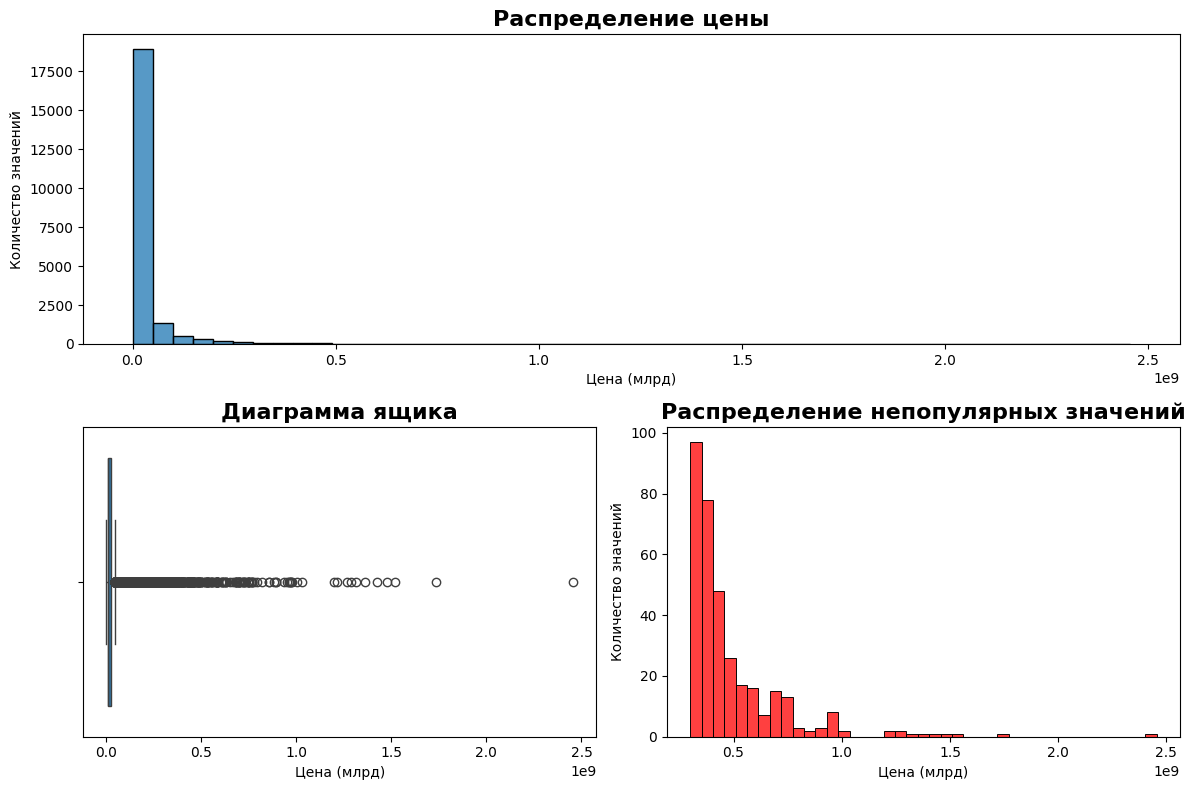

In [ ]:

ax1 = plt.subplot2grid((2, 2), (0, 0), colspan = 2)
sns.histplot(data = df,
             x = 'Цена',
             bins = 50,
             ax = ax1)


ax1.set_title('Распределение цены')
ax1.set_xlabel('Цена (млрд)')
ax1.set_ylabel('Количество значений')


ax2 = plt.subplot2grid((2, 2), (1, 0))
sns.boxplot(data = df, x = 'Цена', ax = ax2)
ax2.set_title('Диаграмма ящика')
ax2.set_xlabel('Цена (млрд)')


unpopular = df[df['Цена'] >= 0.3 * 10**9]
ax3 = plt.subplot2grid((2, 2), (1, 1))
sns.histplot(data = unpopular,
             x = 'Цена',
             ax = ax3,
            color = 'red')
ax3.set_title('Распределение непопулярных значений')
ax3.set_xlabel('Цена (млрд)')
ax3.set_ylabel('Количество значений')


plt.tight_layout()
plt.show()



**Выводы:**

1. Значения цены распределены преимущественно на небольшом диапазоне
2. Диаграмма с ящиком показывает, что в данных есть аномальные значения
3. Можно сделать очевидный вывод, что чем дороже квартира, тем меньше их в наборе данных



###   Площадь

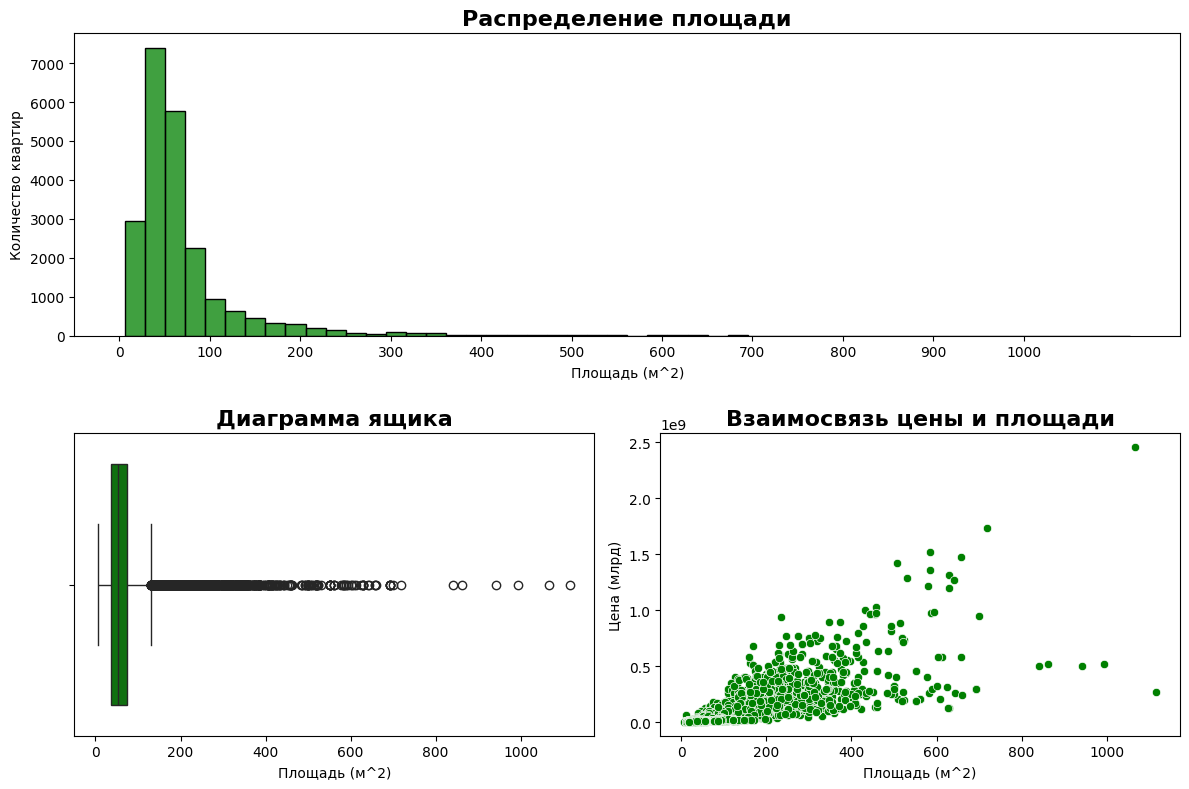

In [ ]:

ax1 = plt.subplot2grid((2, 2), (0, 0), colspan = 2)
sns.histplot(data = df,
             x = 'Площадь',
             bins = 50,
             ax = ax1,
             color = 'g')
ax1.set_title('Распределение площади')
ax1.set_ylabel('Количество квартир')
ax1.set_xlabel('Площадь (м^2)')
ax1.set_xticks(range(0,1001,100))


ax2 = plt.subplot2grid((2, 2), (1, 0))
sns.boxplot(data = df, x = 'Площадь', ax = ax2, color = 'g')
ax2.set_title('Диаграмма ящика')
ax2.set_xlabel('Площадь (м^2)')


ax3 = plt.subplot2grid((2, 2), (1, 1))
sns.scatterplot(data = df,
                x = 'Площадь',
                y = 'Цена',
                ax = ax3,
                color = 'g')

corelation = round(df[['Площадь', 'Цена']].corr()['Цена'].loc['Площадь'],2)
ax3.set_title(f'Взаимосвязь цены и площади')
ax3.set_xlabel('Площадь (м^2)')
ax3.set_ylabel('Цена (млрд)')


plt.tight_layout()
plt.show()



**Выводы:**
1. Значения площади распложены преимущественно в диапазоне до 100 м^2
2. Диаграмма с ящиком показывает, что в данных есть выбросы


После визуализации признаков `Цена` и `Площадь`, можно сказать, что так как во всех признаках есть аномальные значения,то все эти аномальные значения связаны с высокой ценой.
 Количество аномальных значений по каждому признаку примерно равно
Следовательно, пока будем работать с полным набором данных и не будем делать никаких преобразований с выбросами


#### Посчитаем  количество аномальных значений

In [ ]:

number_extreme = pd.DataFrame()
list_index = []
list_values = []

for i in describe.index:

    doorstep = describe['75%'].loc[i]
    set = df[df[i] > doorstep]
    set = set.describe().T
    list_index.append(i)
    list_values.append(set['count'].loc[i])

number_extreme.index = list_index
number_extreme['Количество аномальных значений'] = list_values
number_extreme

,Количество аномальных значений
Цена,5453.0
Минут до метро,5276.0
Количество комнат,3230.0
Площадь,5452.0
Жилая площадь,5428.0
Кухня площадь,5452.0
Этаж,5046.0
Количество этажей,4020.0


### Взаимосвязь между признаками

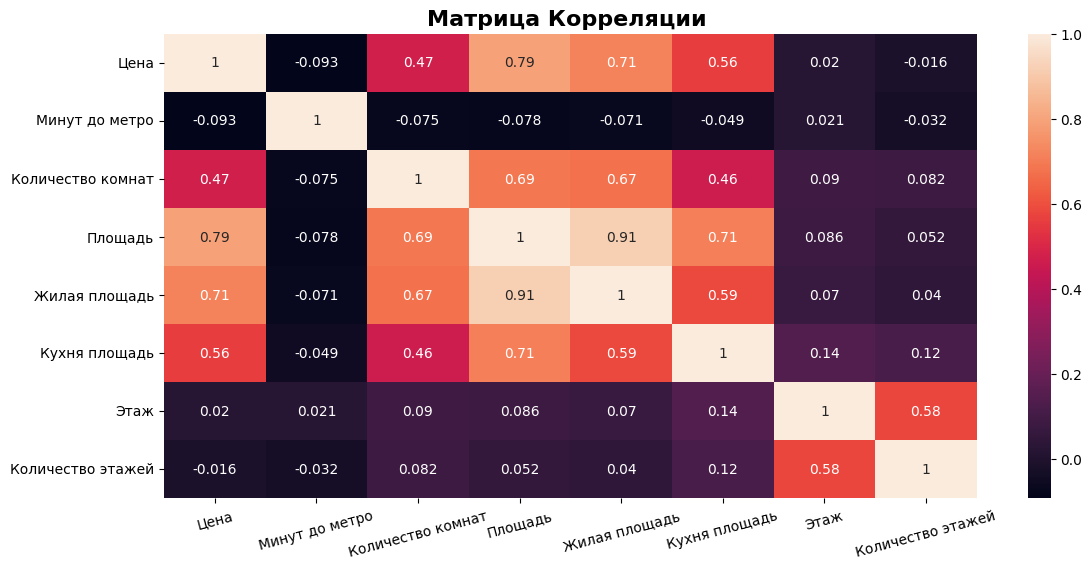

In [ ]:
correlation = df.select_dtypes(include = ['float64', 'int64']).corr()
fig = plt.figure(figsize=(12, 16))

ax1 = plt.subplot2grid((6, 2), (0, 0), rowspan = 2, colspan = 2)
sns.heatmap(correlation, annot = True, ax = ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15)
ax1.set_title('Матрица Корреляции ')
plt.tight_layout()
plt.show()

**Вывод:**

1. Существует зависимость между `Цена` (целевая переменная) и признаками:Количество комнат,Площадь,Жилая площадь,Площадь кухни
2. Существует мультиколлинеарность между признаками `Жилая площадь` и `Площадь`
Удалим признак `Жилая площадь`.

In [ ]:
df.drop('Жилая площадь', axis = 1, inplace = True)


## LinearRegression

В качестве первой модели, построим модель линейной регрессии.



Выделим отдельно целевую переменную и исходные признаки

In [ ]:

y = df['Цена']
X = df[['Количество комнат', 'Площадь', 'Кухня площадь']]

X = sm.add_constant(X)
linear_model = sm.OLS(y,X)
result = linear_model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   Цена   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                 1.272e+04
Date:                Mon, 10 Jun 2024   Prob (F-statistic):               0.00
Time:                        11:18:07   Log-Likelihood:            -4.1631e+05
No. Observations:               21813   AIC:                         8.326e+05
Df Residuals:                   21809   BIC:                         8.327e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -2.715e+07   6.86e+0

In [ ]:
y = df['Цена']
X = df[['Количество комнат', 'Площадь']]

X = sm.add_constant(X)
linear_model = sm.OLS(y,X)
result = linear_model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   Цена   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                 1.908e+04
Date:                Mon, 10 Jun 2024   Prob (F-statistic):               0.00
Time:                        11:18:12   Log-Likelihood:            -4.1631e+05
No. Observations:               21813   AIC:                         8.326e+05
Df Residuals:                   21810   BIC:                         8.327e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -2.783e+07   5.43e+0

Разделим данные на обучающую (70%) и тестовую (30%) части

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 10)

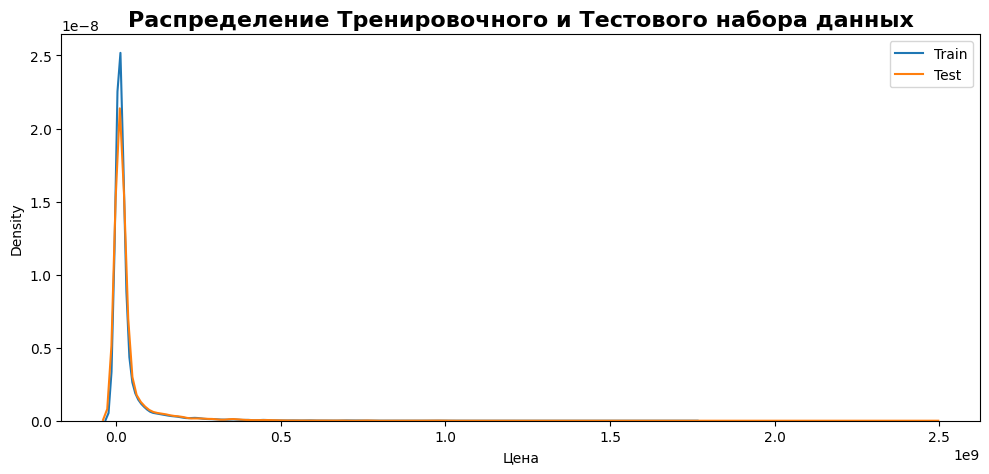

In [ ]:
plt.subplots(figsize = (10,5))
sns.kdeplot(y_train, label = 'Train')
sns.kdeplot(y_test, label = 'Test')

plt.title('Распределение Тренировочного и Тестового набора данных')
plt.legend()
plt.tight_layout()
plt.show()

Натренируем модель на данных, а потом протестируем  и оценим

# Обучение модели

Создадим модель линейной регрессии

In [ ]:
lr = LinearRegression()
#Обучаем модель на наших данных
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [ ]:
def save_fig(folder_name, file_name):


    file_path = os.path.join(folder_name, file_name)

    return file_path

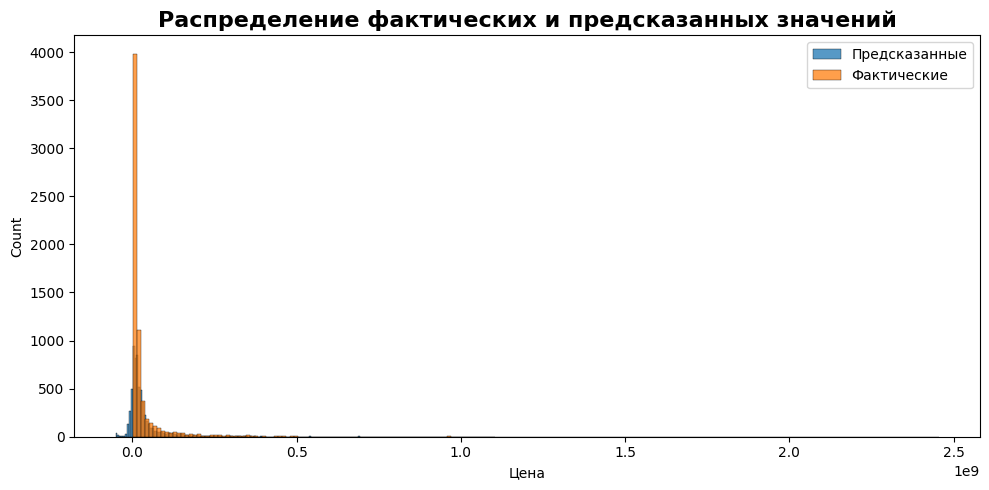

In [ ]:
plt.subplots(figsize = (10,5))
sns.histplot(y_pred, bins = 200, label = 'Предсказанные')
sns.histplot(y_test, bins = 200, label = 'Фактические')

plt.title('Распределение фактических и предсказанных значений')
plt.legend()
plt.tight_layout()

plt.show()

Видно, что модель занижает значения цен. Дальше оценим метрики модели

## Тренируем на полном наборе данных

In [ ]:
lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

## Получение метрик

In [ ]:
mape = metric(lr, X, y)[0].mean()
mae = metric(lr, X, y)[1].mean()
mse = metric(lr, X, y)[2].mean()
rmse = np.sqrt(mse)

print('MAPE:', mape)
print('MAE:', mae)
print('RMSE:', rmse)
r_squared = lr.score(X, y)

print(f'R^2: {r_squared}')

MAPE: 1.2270859230791051
MAE: 21055504.792189833
RMSE: 48600889.3770694
R^2: 0.6362697781667397


### Сохраняем данные LinearRegression

In [ ]:
def save_data(data, folder_name, file_name):
    file_path = os.path.join(folder_name, file_name)
    data.to_csv(file_path, index=False)

In [ ]:
X['Цена'] = y
# save_data(X, 'Данные', 'LRegress.csv')

## RandomForest на числовых признаках

Построим базовую модель случайного леса.



In [ ]:
X.drop('Цена', axis = 1, inplace = True)

In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

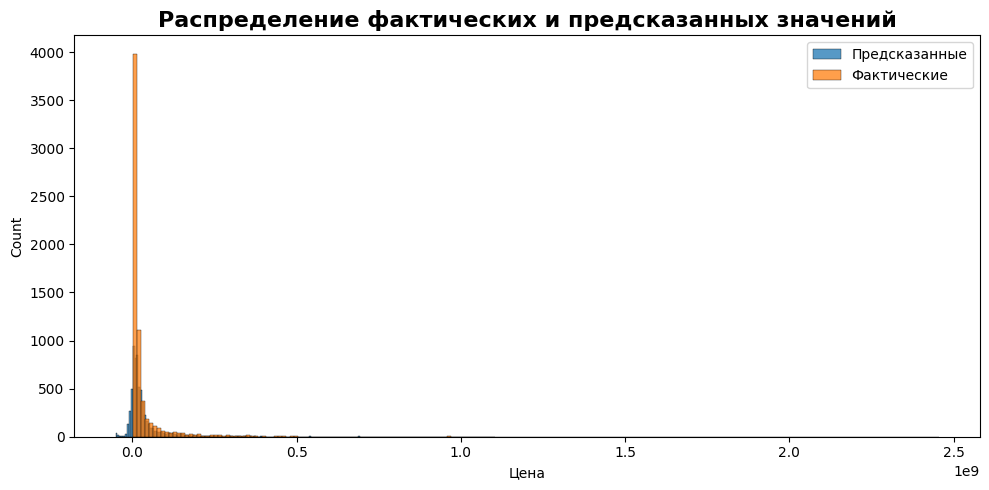

In [ ]:
fig2 = plt.subplots(figsize = (10,5))
sns.histplot(y_pred, bins = 200, label = 'Предсказанные')
sns.histplot(y_test, bins = 200, label = 'Фактические')

plt.title('Распределение фактических и предсказанных значений')
plt.legend()
plt.tight_layout()
plt.show()

 По графику видно, что плотности распределений предсказанных значений и фактических значений лучше совпадают.



### Получение метрик из функции

In [ ]:

mape = metric(rf, X, y)[0].mean()
mae = metric(rf, X, y)[1].mean()
mse = metric(rf, X, y)[2].mean()
rmse = np.sqrt(mse)

# Вывод метрик модели
print('MAPE:', mape)
print('MAE:', mae)
print('RMSE:', rmse)
r_squared = rf.score(X, y)
print(f'R^2: {r_squared}')

MAPE: 0.5583793103796607
MAE: 16668940.945447356
RMSE: 51467605.5414434
R^2: 0.8136580597728096


### Сохранение набора данных для Линейной регрессии

In [ ]:
#X['Цена'] = y
#save_data(X, 'Данные', ' RandomForest.csv')

## RandomForest с полным набором

In [ ]:
X = df.copy()
X.drop(['Адрес', 'Ссылка', 'Цена'], axis = 1, inplace = True)
y = df['Цена']

In [ ]:
X.head(3)

,Тип квартиры,Станция метро,Минут до метро,Регион,Количество комнат,Площадь,Кухня площадь,Этаж,Количество этажей,Ремонт
0,Вторичное,опалиха,6.0,Московская область,1.0,30.6,8.5,25.0,25,Косметический
1,Вторичное,павшино,2.0,Московская область,1.0,49.2,10.0,6.0,15,Евроремонт
2,Вторичное,мякинино,14.0,Московская область,1.0,44.7,13.1,10.0,25,Косметический


In [ ]:
label_encoder = LabelEncoder()
X['Станция метро'] = label_encoder.fit_transform(X['Станция метро'])
X['Тип квартиры'] = label_encoder.fit_transform(X['Тип квартиры'])
X['Регион'] = label_encoder.fit_transform(X['Регион'])
X['Ремонт'] = label_encoder.fit_transform(X['Ремонт'])

In [ ]:
X.head(3)

,Тип квартиры,Станция метро,Минут до метро,Регион,Количество комнат,Площадь,Кухня площадь,Этаж,Количество этажей,Ремонт
0,0,173,6.0,1,1.0,30.6,8.5,25.0,25,3
1,0,180,2.0,1,1.0,49.2,10.0,6.0,15,2
2,0,145,14.0,1,1.0,44.7,13.1,10.0,25,3


In [ ]:
rf_cat = RandomForestRegressor()
rf_cat.fit(X,y)

RandomForestRegressor()

In [ ]:
m = metric(rf_cat, X, y)

In [ ]:
mape = m[0].mean()
mae = m[1].mean()
mse = m[2].mean()
rmse = np.sqrt(mse)

print('MAPE:', mape)
print('MAE:', mae)
print('RMSE:', rmse)
r_squared = rf_cat.score(X, y)
print(f'R^2: {r_squared}')

MAPE: 0.2528493099473405
MAE: 11529203.826829664
RMSE: 44660211.670330934
R^2: 0.9710041655843722


In [ ]:
import pickle

# Сохранение модели RandomForestRegressor
with open('rf_cat_model.pkl', 'wb') as file:
    pickle.dump(rf_cat, file)

## RandomForest с категориальными признаками

Добавим к  признакам еще и категориальные столбцы.

Закодируем их и построим  модель.

In [ ]:
X = df.copy()
X.drop(['Адрес', 'Ссылка', 'Цена'], axis = 1, inplace = True)
y = df['Цена']

In [ ]:
cat = X.select_dtypes(include = ['object'])
cat.nunique()

Тип квартиры       2
Станция метро    310
Регион             2
Ремонт             4
dtype: int64

Что касается другимх категориальных переменных:
1. Закодируем данные признаки - `Тип квартиры`, `Регион`, `Ремонт` с помощью OneHotEncoder.
2. После преобразования над столбцом `Станция метро` использвем кодирование LabelEbcoder чтобы избеджать слишком большого количества столбцов

Закодируем признаки

In [ ]:

encoder = ['Тип квартиры', 'Регион', 'Ремонт']

for e in encoder:
    X = pd.get_dummies(X, columns=[e])

dummies = list(X.columns[7:])
X[dummies] = X[dummies].astype(int)
X.head(3)

,Станция метро,Минут до метро,Количество комнат,Площадь,Кухня площадь,Этаж,Количество этажей,Тип квартиры_Вторичное,Тип квартиры_Новостройка,Регион_Москва,Регион_Московская область,Ремонт_Без ремонта,Ремонт_Дизайнерский,Ремонт_Евроремонт,Ремонт_Косметический
0,опалиха,6.0,1.0,30.6,8.5,25.0,25,1,0,0,1,0,0,0,1
1,павшино,2.0,1.0,49.2,10.0,6.0,15,1,0,0,1,0,0,1,0
2,мякинино,14.0,1.0,44.7,13.1,10.0,25,1,0,0,1,0,0,0,1


In [ ]:
X.dtypes

Станция метро                 object
Минут до метро               float64
Количество комнат            float64
Площадь                      float64
Кухня площадь                float64
Этаж                         float64
Количество этажей              int64
Тип квартиры_Вторичное         int64
Тип квартиры_Новостройка       int64
Регион_Москва                  int64
Регион_Московская область      int64
Ремонт_Без ремонта             int64
Ремонт_Дизайнерский            int64
Ремонт_Евроремонт              int64
Ремонт_Косметический           int64
dtype: object

 Кодируем с помощью LabelEncoder

In [ ]:
label_encoder = LabelEncoder()
X['Станция метро'] = label_encoder.fit_transform(X['Станция метро'])

In [ ]:
X.head()

,Станция метро,Минут до метро,Количество комнат,Площадь,Кухня площадь,Этаж,Количество этажей,Тип квартиры_Вторичное,Тип квартиры_Новостройка,Регион_Москва,Регион_Московская область,Ремонт_Без ремонта,Ремонт_Дизайнерский,Ремонт_Евроремонт,Ремонт_Косметический
0,173,6.0,1.0,30.6,8.5,25.0,25,1,0,0,1,0,0,0,1
1,180,2.0,1.0,49.2,10.0,6.0,15,1,0,0,1,0,0,1,0
2,145,14.0,1.0,44.7,13.1,10.0,25,1,0,0,1,0,0,0,1
3,244,8.0,1.0,35.1,11.0,12.0,33,1,0,0,1,0,0,1,0
4,173,6.0,1.0,37.7,4.0,5.0,5,1,0,0,1,1,0,0,0


In [ ]:
X.dtypes

Станция метро                  int64
Минут до метро               float64
Количество комнат            float64
Площадь                      float64
Кухня площадь                float64
Этаж                         float64
Количество этажей              int64
Тип квартиры_Вторичное         int64
Тип квартиры_Новостройка       int64
Регион_Москва                  int64
Регион_Московская область      int64
Ремонт_Без ремонта             int64
Ремонт_Дизайнерский            int64
Ремонт_Евроремонт              int64
Ремонт_Косметический           int64
dtype: object

После всех преобразований у нас не осталось категориальных столбцов, а все категориальные значения преобразованы в цифры

Mожно тренировать модель RandomForest с добавленными  признаками

In [ ]:
rf_cat = RandomForestRegressor()
rf_cat.fit(X,y)

RandomForestRegressor()

In [ ]:
m = metric(rf_cat, X, y)

### Получение метрик из функции

In [ ]:

mape = m[0].mean()
mae = m[1].mean()
mse = m[2].mean()
rmse = np.sqrt(mse)

print('MAPE:', mape)
print('MAE:', mae)
print('RMSE:', rmse)
r_squared = rf_cat.score(X, y)
print(f'R^2: {r_squared}')

MAPE: 0.2562478570674436
MAE: 11712829.407941738
RMSE: 44692458.96279989
R^2: 0.9707828105468701


### Оценка вожности признаков модели

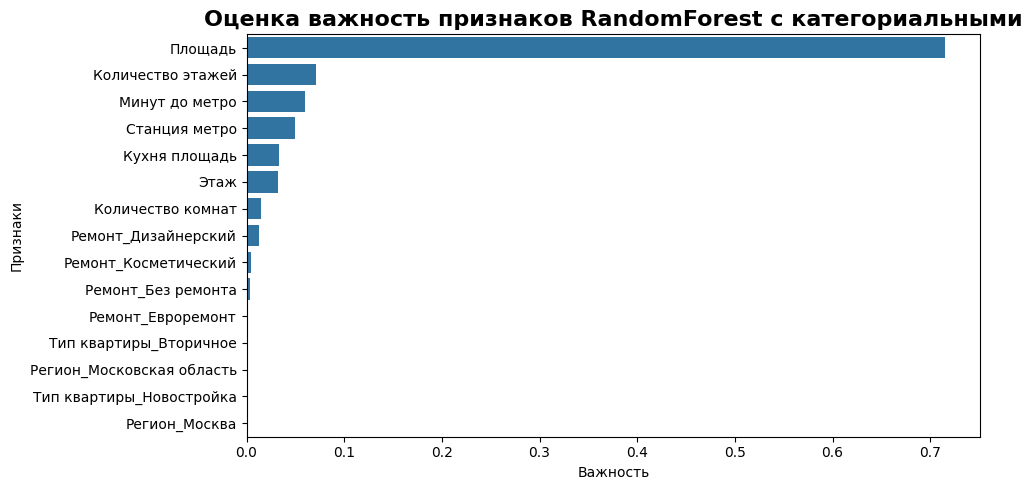

In [ ]:
feature_importance = rf_cat.feature_importances_
feature_names = X.columns

importance = pd.DataFrame()
importance.index = feature_names
importance['Важность'] = feature_importance
importance = importance.sort_values(by = 'Важность', ascending = False)

fig1 = plt.subplots(figsize = (10,5))
sns.barplot(data = importance,
            y = importance.index,
            x = 'Важность')

plt.ylabel('Признаки')
plt.title('Оценка важность признаков RandomForest с категориальными')
#plt.savefig(save_fig('figures', "Оценка важность признаков RandomForest_cat.png"))
plt.tight_layout()
plt.show()

 Значения никак не влияют на цену дома. Самым важным признаком оказался признак `Площадь`. Так же можно заметить что существенное влияние из категориальных признаков оказывает `Станция метро`

То есть можно сделать вывод, что для данной модели важны только числовые значения и станция метро.

## CatBoost с категориальными переменными

### Создадим Pool для  CatBoost

Определение категориальных переменных и разделение данных

'train_pool' используется для обучения модели, 'val_pool' для валидации (оценки качества модели на данных, которые модель ранее не "видела"), а 'full_pool' содержит все данные

In [ ]:
X = df.copy()
X.drop(['Адрес', 'Ссылка', 'Цена'], axis = 1, inplace = True)
y = df['Цена']
category = list(X.select_dtypes(include = ['object']).columns)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size = 0.3,
                                                  shuffle = True,
                                                  random_state = 42)

train_pool = Pool(data = X_train, label = y_train, cat_features = category)
val_pool = Pool(data = X_val, label = y_val, cat_features = category)
full_pool = Pool(data = X, label = y, cat_features = category)

print('Train Pool\n', train_pool.shape)
print('\nValidation Pool\n', val_pool.shape)
print('\nFull Pool\n', full_pool.shape)

Train Pool
 (15269, 10)

Validation Pool
 (6544, 10)

Full Pool
 (21813, 10)


 Тренировка  без гиперпараметров

In [ ]:
catboost = CatBoostRegressor(loss_function = 'MAPE')

catboost.fit(train_pool,
             eval_set = val_pool,
             verbose = 200,
             plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4889812	test: 0.4885503	best: 0.4885503 (0)	total: 12.7ms	remaining: 12.7s
200:	learn: 0.3841561	test: 0.3824091	best: 0.3824091 (200)	total: 2.8s	remaining: 11.1s
400:	learn: 0.3793272	test: 0.3776064	best: 0.3776064 (400)	total: 6.82s	remaining: 10.2s
600:	learn: 0.3792519	test: 0.3775430	best: 0.3775430 (600)	total: 8.84s	remaining: 5.87s
800:	learn: 0.3792283	test: 0.3775237	best: 0.3775237 (800)	total: 12.8s	remaining: 3.17s
999:	learn: 0.3792172	test: 0.3775164	best: 0.3775164 (988)	total: 15s	remaining: 0us

bestTest = 0.3775163988
bestIteration = 988

Shrink model to first 989 iterations.


 Оценка  с помощью кросс валидации

In [ ]:
params = {'loss_function' : 'MAPE'}
mape = cv(pool = full_pool,
          params = params,
          fold_count = 3,
          plot = False,
          verbose = False)

params = {'loss_function' : 'MAE'}
mae = cv(pool = full_pool,
          params = params,
          fold_count = 3,
          plot = False,
          verbose = False)

params = {'loss_function' : 'RMSE'}
rmse = cv(pool = full_pool,
          params = params,
          fold_count = 3,
          plot = False,
          verbose = False)

Training on fold [0/3]

bestTest = 0.3345314586
bestIteration = 998

Training on fold [1/3]

bestTest = 0.3301036092
bestIteration = 999

Training on fold [2/3]

bestTest = 0.3387427922
bestIteration = 999

Training on fold [0/3]

bestTest = 9371408.382
bestIteration = 998

Training on fold [1/3]

bestTest = 8962297.022
bestIteration = 999

Training on fold [2/3]

bestTest = 10146717.6
bestIteration = 999

Training on fold [0/3]

bestTest = 38458530.04
bestIteration = 300

Training on fold [1/3]

bestTest = 37787859.93
bestIteration = 990

Training on fold [2/3]

bestTest = 39823435.66
bestIteration = 998



Получение лучшего значения метрик

In [ ]:
best_iteration = mape['test-MAPE-mean'].idxmin()
best_mape = mape.loc[best_iteration, 'test-MAPE-mean']
mape = best_mape
best_iteration = mae['test-MAE-mean'].idxmin()
best_mae = mae.loc[best_iteration, 'test-MAE-mean']
mae = best_mae
best_iteration = rmse['test-RMSE-mean'].idxmin()
best_rmse = rmse.loc[best_iteration, 'test-RMSE-mean']

rmse = best_rmse

print('MAPE:', mape)
print('MAE:', mae)
print('RMSE:', rmse)


MAPE: 0.3344592879244175
MAE: 9493485.490189165
RMSE: 38970945.77949244


### Оценка важности признаков при обучении

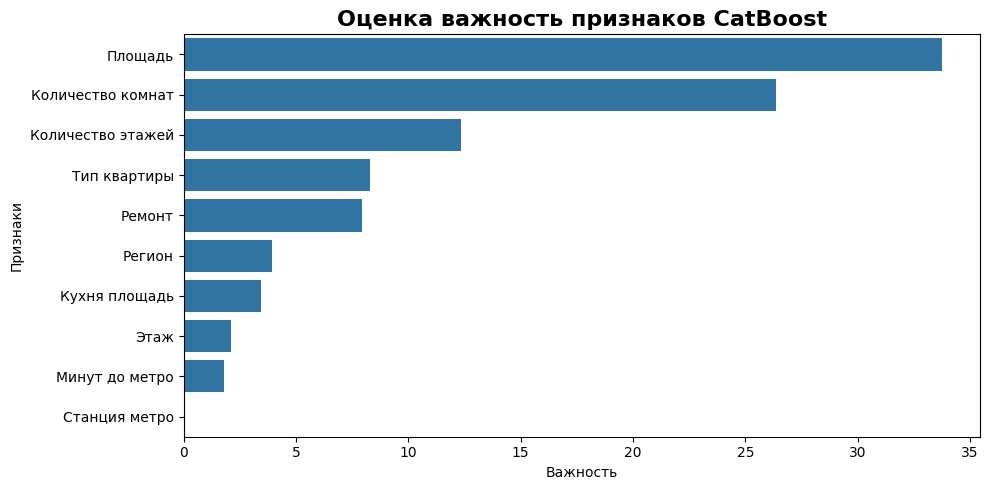

In [ ]:
feature_importance = catboost.feature_importances_
feature_names = X.columns

importance = pd.DataFrame()
importance.index = feature_names
importance['Важность'] = feature_importance
importance = importance.sort_values(by = 'Важность', ascending = False)

fig1 = plt.subplots(figsize = (10,5))
sns.barplot(data = importance,
            y = importance.index,
            x = 'Важность')

plt.ylabel('Признаки')
plt.title('Оценка важность признаков CatBoost')
#plt.savefig(save_fig('figures', "Оценка важность признаков CatBoost.png"))
plt.tight_layout()
plt.show()

При использовании данной модели - признак `Станция метро` никак не повлиял на модель, то есть его в целом можно убрать из модели.

In [ ]:
X['Цена'] = y
#save_data(X, 'Данные', ' Catboost.csv')

## Улучшение качества модели

Построим диаграмму boxplot для признаков

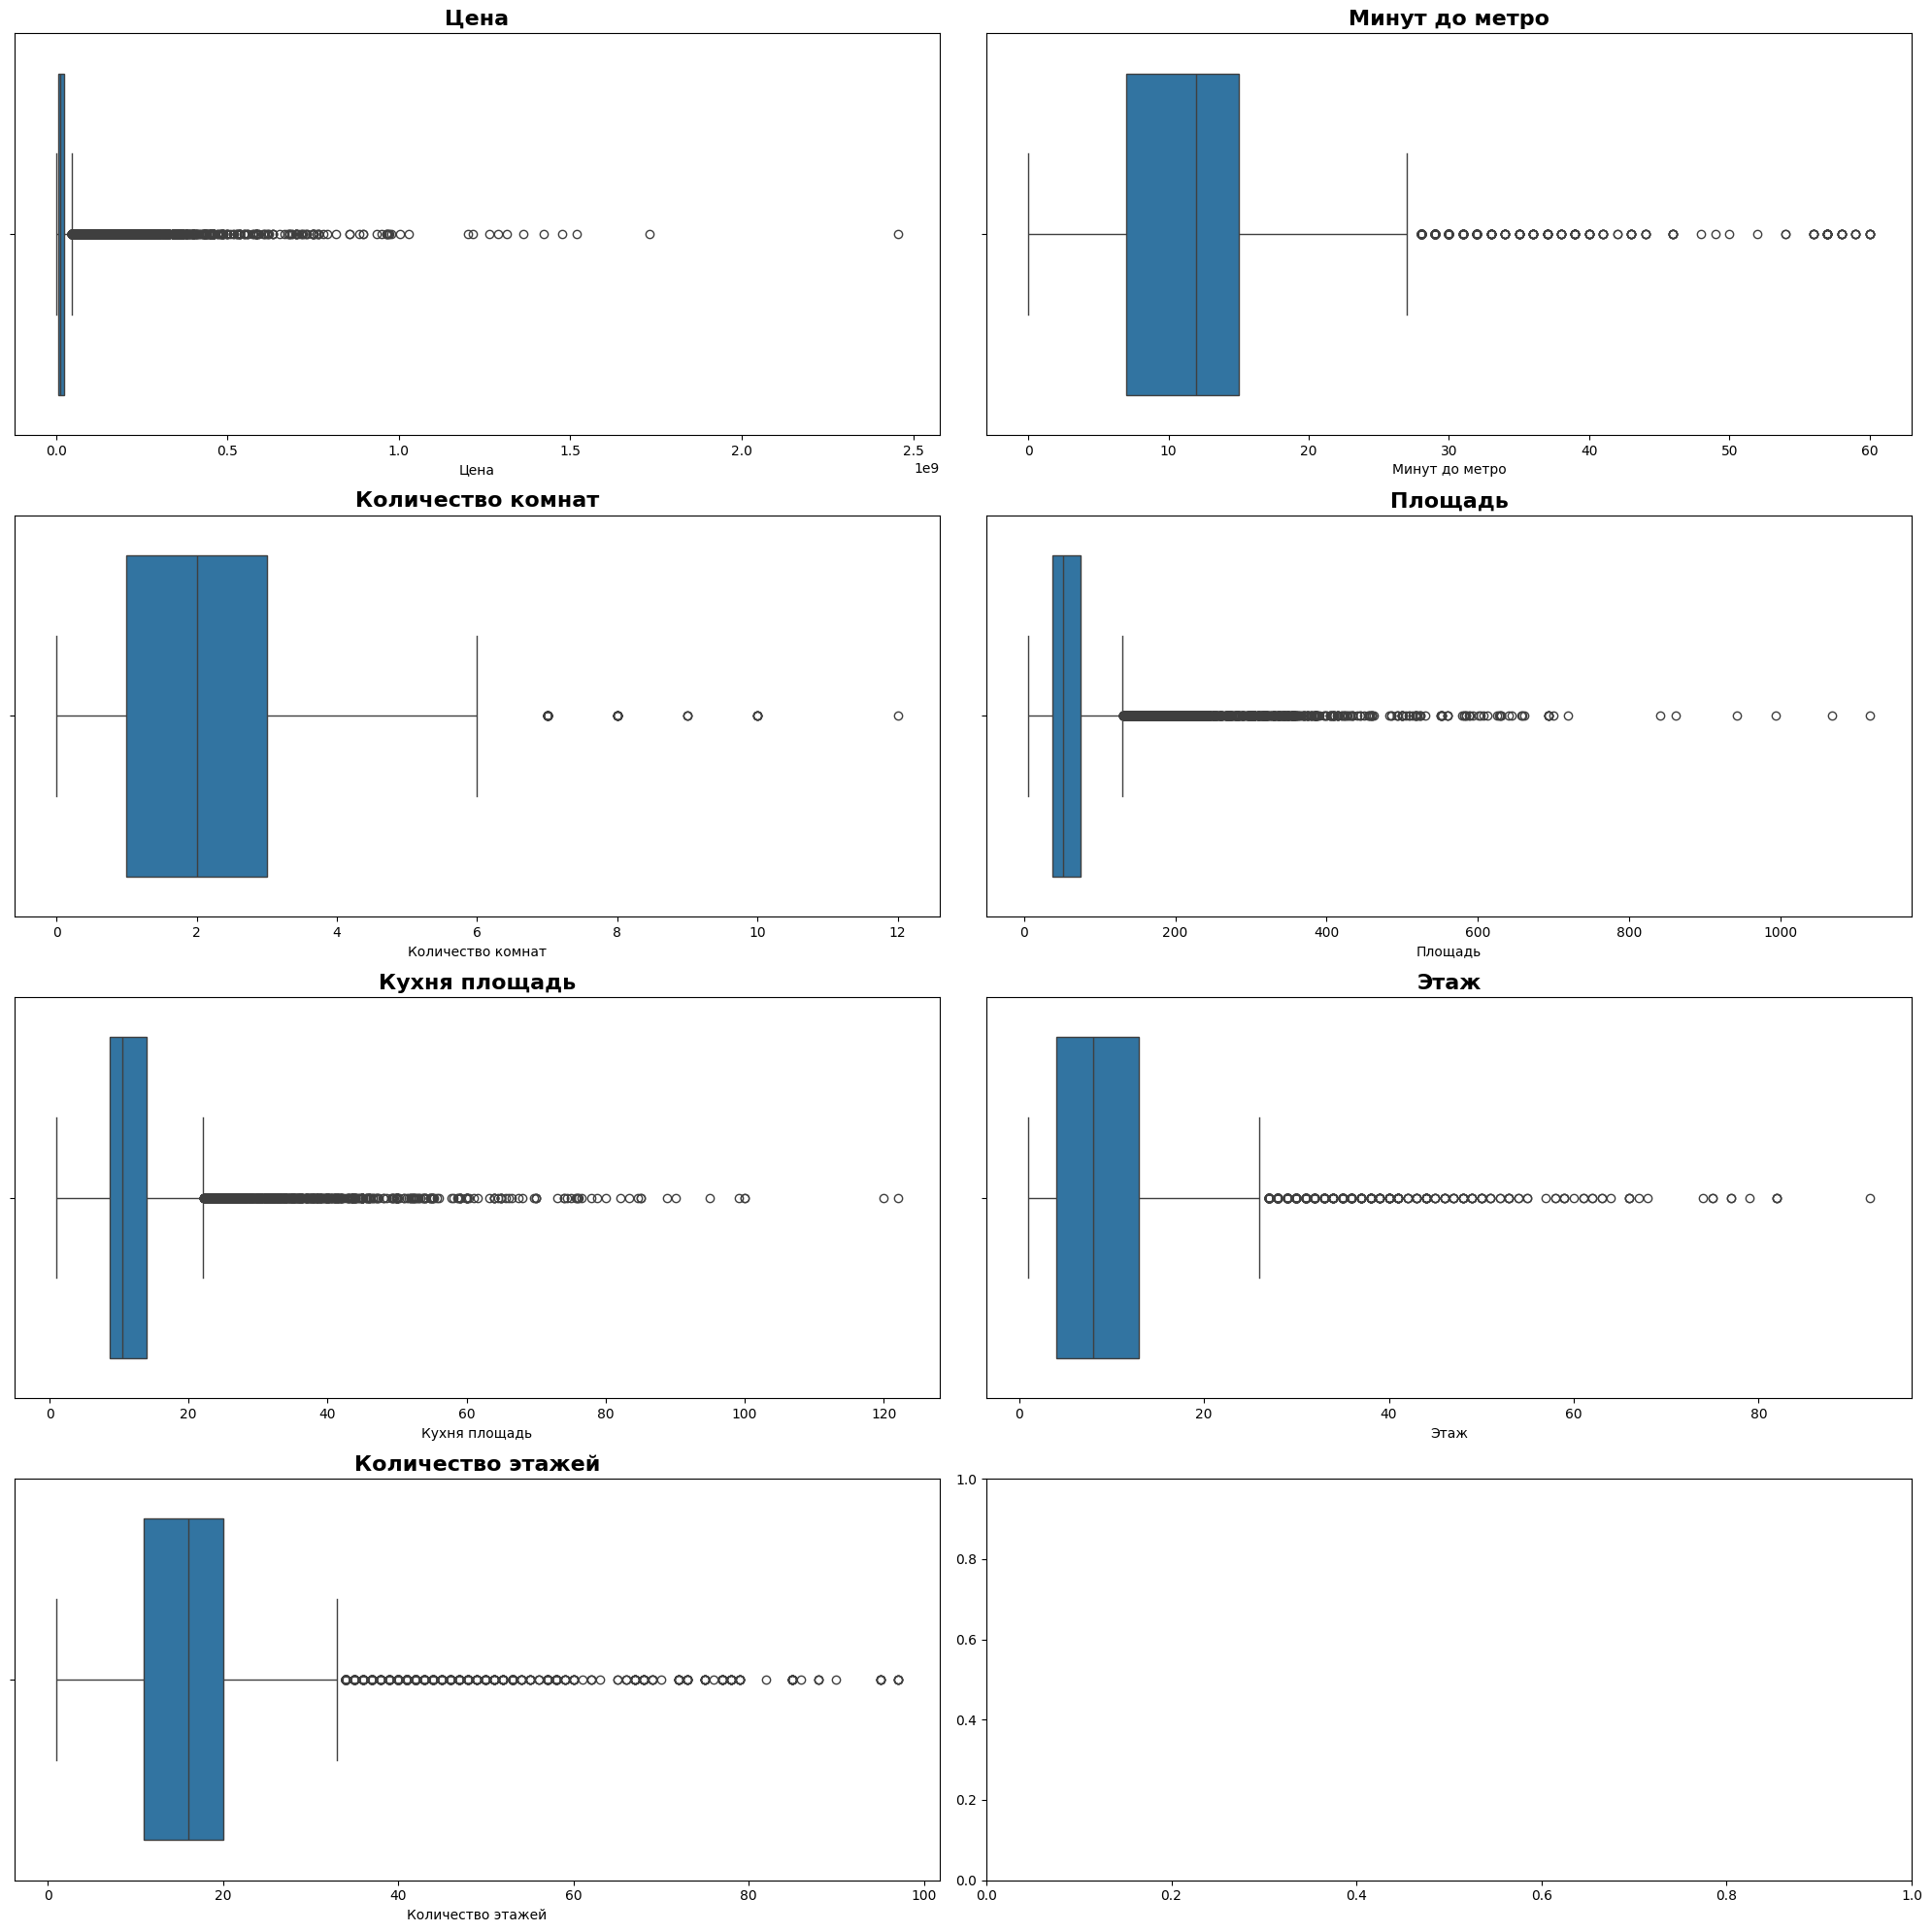

In [ ]:
numeric_lst = list(df.select_dtypes(include = ['float64', 'int64']).columns)

fig, axes = plt.subplots(4,2, figsize = (20,20))

for i, n in enumerate(numeric_lst):
    ax = axes[i // 2,i % 2]
    sns.boxplot(data = df,
                x = n,
                ax = ax)
    ax.set_title(n)

plt.tight_layout()
plt.show()

Выбросы  будем заменять на средние значения этих переменных

Выбирем для такой задачи метод замены выбросов(с помощью IQR метода)


Список со значениями, где надо заменить выбросы

In [ ]:
emissions = df.select_dtypes(include = ['float64', 'int64'])
emissions.drop('Количество комнат', axis = 1, inplace = True)
emissions_lst = list(emissions.columns)
emissions_lst

['Цена',
 'Минут до метро',
 'Площадь',
 'Кухня площадь',
 'Этаж',
 'Количество этажей']

### Функция заменяющая выбросы в признаках

In [ ]:
X = df[['Цена', 'Тип квартиры', 'Станция метро', 'Минут до метро', 'Регион',
        'Количество комнат', 'Площадь', 'Кухня площадь', 'Этаж', 'Количество этажей', 'Ремонт']]
X.head(7)

,Цена,Тип квартиры,Станция метро,Минут до метро,Регион,Количество комнат,Площадь,Кухня площадь,Этаж,Количество этажей,Ремонт
0,6300000.0,Вторичное,опалиха,6.0,Московская область,1.0,30.6,8.5,25.0,25,Косметический
1,9000000.0,Вторичное,павшино,2.0,Московская область,1.0,49.2,10.0,6.0,15,Евроремонт
2,11090000.0,Вторичное,мякинино,14.0,Московская область,1.0,44.7,13.1,10.0,25,Косметический
3,8300000.0,Вторичное,строгино,8.0,Московская область,1.0,35.1,11.0,12.0,33,Евроремонт
4,6450000.0,Вторичное,опалиха,6.0,Московская область,1.0,37.7,4.0,5.0,5,Без ремонта
5,7150000.0,Вторичное,опалиха,6.0,Московская область,1.0,38.4,8.0,8.0,18,Евроремонт
6,7400000.0,Вторичное,нахабино,11.0,Московская область,1.0,33.0,8.0,7.0,7,Евроремонт


In [ ]:
def iqr_replacement(data, list_replace):

    # Замена на медианное значение
    for l in list_replace:
        q1 = data[l].quantile(0.25)
        q3 = data[l].quantile(0.75)

        iqr = q3 - q1

        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        data[l] = data[l].apply(lambda x: data[l].median() if x < lower_bound or x > upper_bound else x)

    return data

In [ ]:
X = iqr_replacement(X, emissions_lst)


<ipython-input-81-802613e0daf1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[l] = data[l].apply(lambda x: data[l].median() if x < lower_bound or x > upper_bound else x)
<ipython-input-81-802613e0daf1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[l] = data[l].apply(lambda x: data[l].median() if x < lower_bound or x > upper_bound else x)
<ipython-input-81-802613e0daf1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

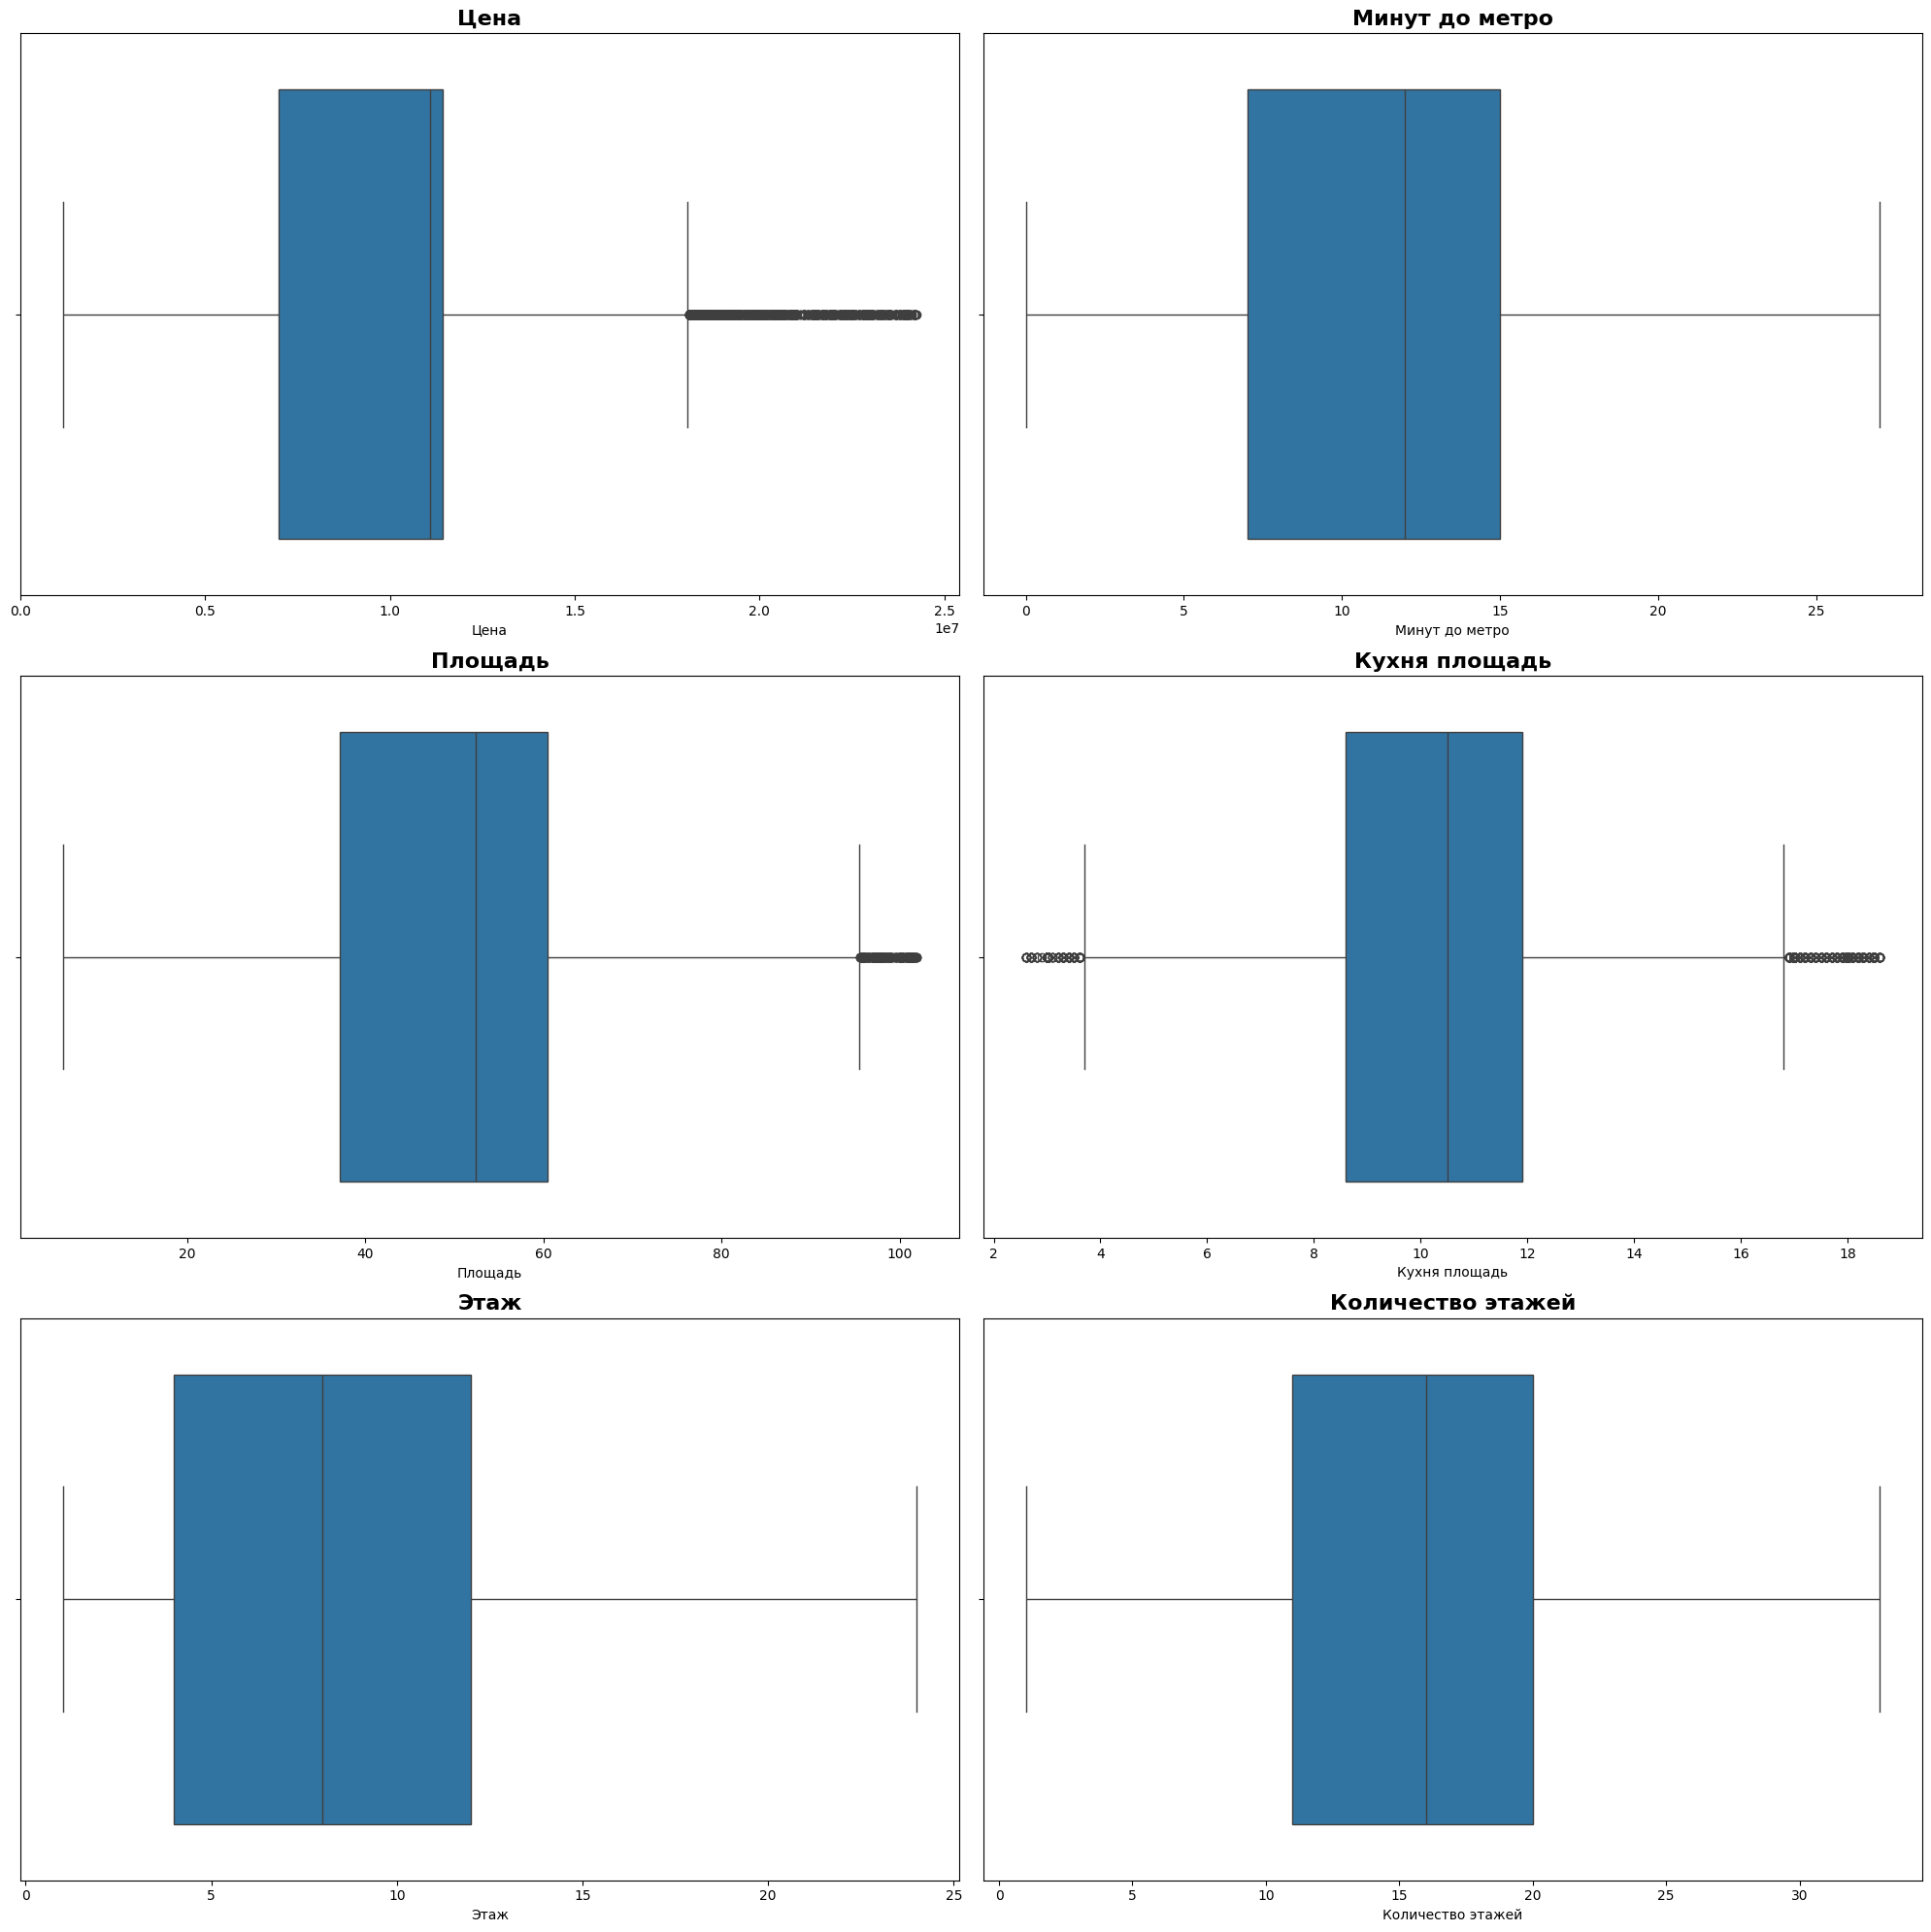

In [ ]:
fig, axes = plt.subplots(3,2, figsize = (20,20))

for i, n in enumerate(emissions_lst):
    ax = axes[i // 2, i % 2]
    sns.boxplot(data = X,
                x = n,
                ax = ax)
    ax.set_title(n)

plt.tight_layout()
plt.show()

На данном наборе стало меньше выбросов в данных ,это поможет модели больше ориентироваться на средние значения





# Тренировка моделей с данными, где были заменены выбросы

In [ ]:
# Данные где заменены выбросы
data = X.copy()
data.head(3)

,Цена,Тип квартиры,Станция метро,Минут до метро,Регион,Количество комнат,Площадь,Кухня площадь,Этаж,Количество этажей,Ремонт
0,6300000.0,Вторичное,опалиха,6.0,Московская область,1.0,30.6,8.5,8.0,25.0,Косметический
1,9000000.0,Вторичное,павшино,2.0,Московская область,1.0,49.2,10.0,6.0,15.0,Евроремонт
2,11090000.0,Вторичное,мякинино,14.0,Московская область,1.0,44.7,13.1,10.0,25.0,Косметический


## Тренировка RandomForest

In [ ]:
# Данные для обучения
y = data['Цена']
X = data.drop('Цена', axis = 1)

### Закодируем категориальные признаки

In [ ]:
# Столбцы которые будем кодировать
encoder = ['Тип квартиры', 'Регион', 'Ремонт']

# Кодируем каждый столбец
for e in encoder:
    X = pd.get_dummies(X, columns=[e])

# Вместо типа данных bool делаем 0 и 1
dummies = list(X.columns[7:])
X[dummies] = X[dummies].astype(int)
X.head(3)

,Станция метро,Минут до метро,Количество комнат,Площадь,Кухня площадь,Этаж,Количество этажей,Тип квартиры_Вторичное,Тип квартиры_Новостройка,Регион_Москва,Регион_Московская область,Ремонт_Без ремонта,Ремонт_Дизайнерский,Ремонт_Евроремонт,Ремонт_Косметический
0,опалиха,6.0,1.0,30.6,8.5,8.0,25.0,1,0,0,1,0,0,0,1
1,павшино,2.0,1.0,49.2,10.0,6.0,15.0,1,0,0,1,0,0,1,0
2,мякинино,14.0,1.0,44.7,13.1,10.0,25.0,1,0,0,1,0,0,0,1


In [ ]:
label_encoder = LabelEncoder()

# Кодируем
X['Станция метро'] = label_encoder.fit_transform(X['Станция метро'])

In [ ]:
X.head(3)

,Станция метро,Минут до метро,Количество комнат,Площадь,Кухня площадь,Этаж,Количество этажей,Тип квартиры_Вторичное,Тип квартиры_Новостройка,Регион_Москва,Регион_Московская область,Ремонт_Без ремонта,Ремонт_Дизайнерский,Ремонт_Евроремонт,Ремонт_Косметический
0,173,6.0,1.0,30.6,8.5,25.0,25.0,1,0,0,1,0,0,0,1
1,180,2.0,1.0,49.2,10.0,6.0,15.0,1,0,0,1,0,0,1,0
2,145,14.0,1.0,44.7,13.1,10.0,25.0,1,0,0,1,0,0,0,1


### Тренируем модель

In [ ]:
# Модель для предсказания с категоримальными признаками
rf_cat = RandomForestRegressor()

# Тренировка модели на всем наборе данных
rf_cat.fit(X,y)

RandomForestRegressor()

In [ ]:
m = metric(rf_cat, X, y)

In [ ]:
# Получение метрик из функции
mape = m[0].mean()
mae = m[1].mean()
mse = m[2].mean()
rmse = np.sqrt(mse)

# Вывод метрик модели LR
print('MAPE:', mape)
print('MAE:', mae)
print('RMSE:', rmse)
r_squared = rf_cat.score(X, y)
print(f'R^2: {r_squared}')

MAPE: 0.14770146228867298
MAE: 1587079.2804771925
RMSE: 2562691.929947446
R^2: 0.9696402070489919


Удаление выбросов привело к значительному улучшению  метрик.

### Оценка важности признаков при тренировке

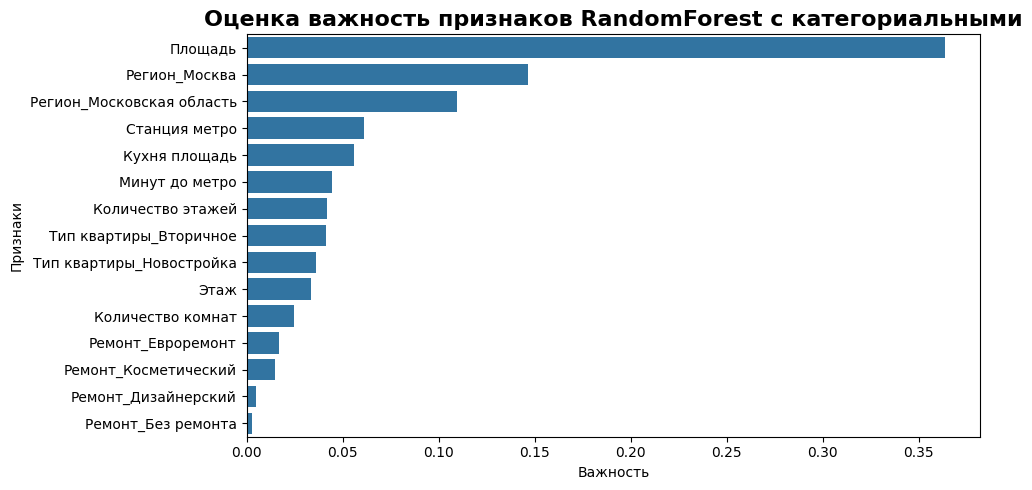

In [ ]:
feature_importance = rf_cat.feature_importances_
feature_names = X.columns

importance = pd.DataFrame()
importance.index = feature_names
importance['Важность'] = feature_importance
importance = importance.sort_values(by = 'Важность', ascending = False)

fig1 = plt.subplots(figsize = (10,5))
sns.barplot(data = importance,
            y = importance.index,
            x = 'Важность')

plt.ylabel('Признаки')
plt.title('Оценка важность признаков RandomForest с категориальными')
# plt.savefig(save_fig('figures', "Оценка важность признаков RandomForest_cat.png"))
plt.tight_layout()
plt.show()

In [ ]:
X['Цена'] = y
#save_data(X, 'Данные', 'RandomForest без выбросов.csv')

# Построение модели с использованием нейронных сетей

##Пример 1

Загрузим данные

In [ ]:
df_n = pd.read_csv('data1_clean_v2.csv')

In [ ]:
df_n.head(5)

,цена,спальня,ванная комната,жилая площадь,площадь участка,этаж,наличие лоджии,качество материалов,квадратные метры внешнего пр-ва,площадь цоколя,год постройки,год рекострукции,широта,долгота
0,221900.0,3,1.00,1180,5650,1.0,0,0,1180,0,1955,0,47.5112,-122.257
1,538000.0,3,2.25,2570,7242,2.0,0,0,2170,400,1951,1991,47.7210,-122.319
2,180000.0,2,1.00,770,10000,1.0,0,0,770,0,1933,0,47.7379,-122.233
3,604000.0,4,3.00,1960,5000,1.0,0,0,1050,910,1965,0,47.5208,-122.393
4,510000.0,3,2.00,1680,8080,1.0,0,0,1680,0,1987,0,47.6168,-122.045


In [ ]:
df_n.rename(columns={'цена': 'price'}, inplace=True)

Выделим отдельно целевую переменную и исходные признаки

In [ ]:
X=df_n.drop('price',axis=1).values

In [ ]:
y=df_n['price'].values

Разделим данные на обучающую  и тестовую части

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

MinMaxScaler используется для нормализации данных, приводя значения признаков к диапазону от 0 до 1.

In [ ]:
scaler=MinMaxScaler()

## Масштабирование данных

In [ ]:
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [ ]:
#!pip install keras

In [ ]:
#!pip install tensorflow==2.8.0

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [ ]:
X_train.shape

(15129, 13)

Для создания модели использовалась последовательная архитектура (Sequential) из библиотеки Keras. Входной слой был настроен на получение 13 признаков. Модель состоит из нескольких полносвязных (Dense) слоев с функцией активации ReLU, а также слоев Dropout для регуляризации.
Модель была скомпилирована с использованием оптимизатора Adam и функции потерь среднеквадратичной ошибки (MSE). .

Улучшения:
*Добавление Dropout:*
Dropout слои добавлены между Dense слоями для регуляризации и предотвращения переобучения.
*Указание размера входных данных:*
input_dim=17 указывает, что входной слой ожидает 17 признаков.
*Раннее прекращение обучения:*
EarlyStopping используется для остановки обучения, если валидационная ошибка не улучшается в течение 20 эпох.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [ ]:

model = Sequential()
model.add(Dense(64, input_dim=13, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Определение раннего прекращения обучения
# early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)


In [ ]:
model.fit(x=X_train,y=y_train,validation_data=(X_test,y_test),batch_size=128,epochs=400)

Epoch 1/400
119/119 [==============================] - 2s 5ms/step - loss: 423414956032.0000 - val_loss: 431318990848.0000
Epoch 2/400
119/119 [==============================] - 0s 4ms/step - loss: 384462749696.0000 - val_loss: 290556772352.0000
Epoch 3/400
119/119 [==============================] - 0s 4ms/step - loss: 153946423296.0000 - val_loss: 99596730368.0000
Epoch 4/400
119/119 [==============================] - 1s 4ms/step - loss: 109812621312.0000 - val_loss: 96271777792.0000
Epoch 5/400
119/119 [==============================] - 1s 4ms/step - loss: 105996468224.0000 - val_loss: 92374835200.0000
Epoch 6/400
119/119 [==============================] - 0s 4ms/step - loss: 103030538240.0000 - val_loss: 88236531712.0000
Epoch 7/400
119/119 [==============================] - 0s 4ms/step - loss: 99189137408.0000 - val_loss: 83332046848.0000
Epoch 8/400
119/119 [==============================] - 0s 4ms/step - loss: 94227267584.0000 - val_loss: 79121326080.0000
Epoch 9/400
119/119 [===

In [ ]:
losses=pd.DataFrame(model.history.history)

<Axes: >

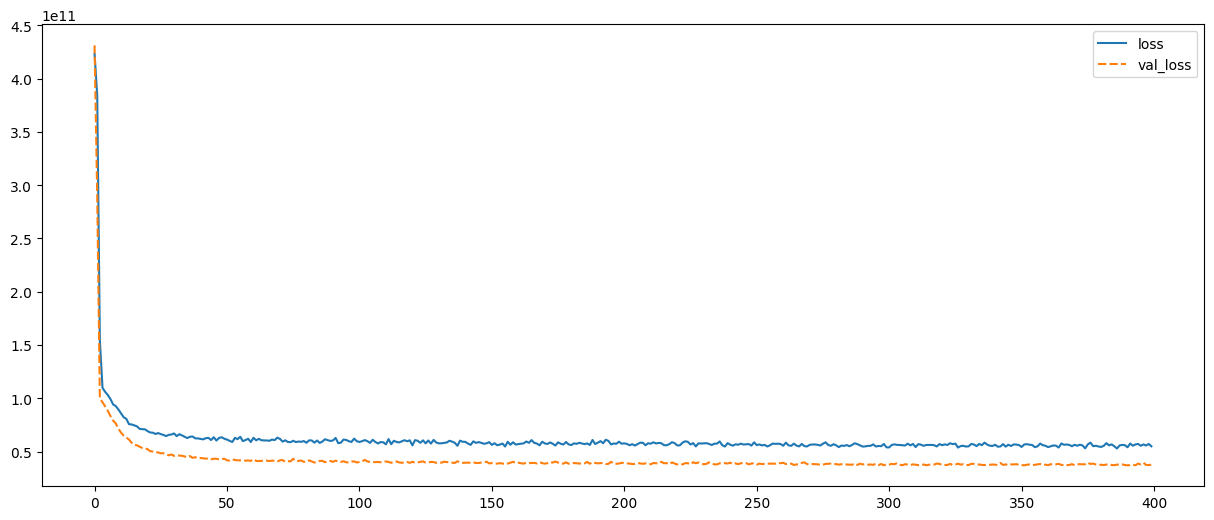

In [ ]:
plt.figure(figsize=(15,6))
sns.lineplot(losses)

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,explained_variance_score

In [ ]:
predictions=model.predict(X_test)

203/203 [==============================] - 0s 1ms/step


In [ ]:
from sklearn.metrics import r2_score
# Выполнение предсказаний на тестовых данных
predictions = model.predict(X_test)

# Оценка метрик
mae = mean_absolute_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
mape = mean_absolute_percentage_error(y_test, predictions)

print(f'MAPE: {mape}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
r2 = r2_score(y_test, predictions.flatten())
print(f'R^2: {r2}')


203/203 [==============================] - 1s 4ms/step
MAPE: 0.22334081245069012
MAE: 119455.01776247301
RMSE: 193901.9056015854
R^2: 0.731969521974985


##Оценка производительности модели

In [ ]:
mean_absolute_error(predictions,y_test)

119455.01776247301

In [ ]:
df_n['price'].describe()

count    2.161300e+04
mean     5.400881e+05
std      3.671272e+05
min      7.500000e+04
25%      3.219500e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

In [ ]:
explained_variance_score(y_test,predictions)

0.7358198386547063

Вывод:Explained Variance Score измеряет долю дисперсии, объясненную моделью. Значение близкое к 1 указывает на то, что модель хорошо объясняет дисперсию данных. Значение 0.8280709904604976 указывает на то, что модель объясняет около 82.8% дисперсии данных, что является хорошим показателем

 ## Построение графика рассеяния

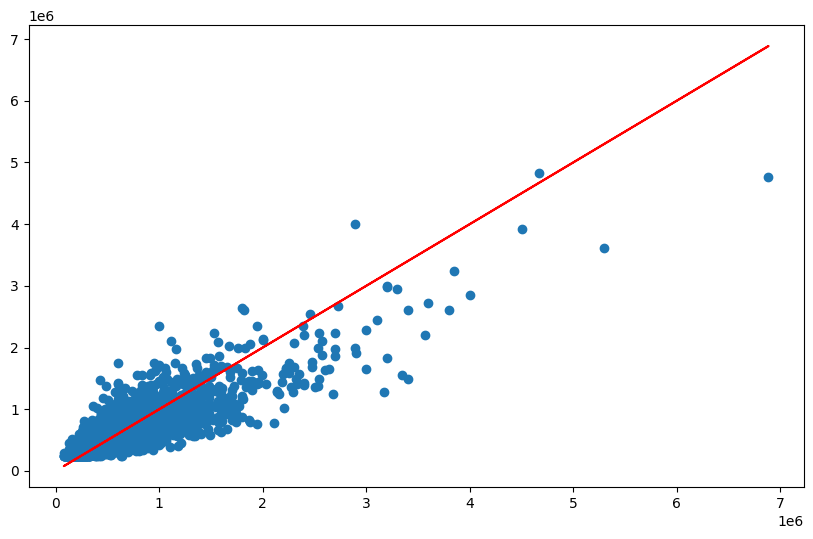

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(y_test,predictions)
plt.plot(y_test,y_test,color='red')

## Предсказание цены

In [ ]:
predict_one=df_n.iloc[0].drop('price').values

In [ ]:
predict_one=predict_one.reshape(-1,13)

In [ ]:
predict_one=scaler.transform(predict_one)

Предсказаная цена

In [ ]:
model.predict(predict_one)

1/1 [==============================] - 0s 34ms/step


array([[266485.3]], dtype=float32)

Фактическая цена

In [ ]:
df_n.iloc[0]['price']

221900.0

Удалим аномальные данные и обучим новую модель нейронной сети для предсказания цен.

In [ ]:
X_new=df_n[df_n['price']<2000000.0].drop('price',axis=1).values
y_new=df_n[df_n['price']<2000000.0]['price'].values

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_new, y_new, test_size=0.3, random_state=101)

In [ ]:
X_train2=scaler.fit_transform(X_train2)
X_test2=scaler.transform(X_test2)

In [ ]:
model2 = Sequential()
model2.add(Dense(64, input_dim=13, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mse')


In [ ]:
history2 = model2.fit(x=X_train2,y=y_train2,validation_data=(X_test2,y_test2),batch_size=128,epochs=400)

Epoch 1/400
118/118 [==============================] - 2s 5ms/step - loss: 353980153856.0000 - val_loss: 342987341824.0000
Epoch 2/400
118/118 [==============================] - 0s 4ms/step - loss: 307814006784.0000 - val_loss: 185433194496.0000
Epoch 3/400
118/118 [==============================] - 1s 4ms/step - loss: 94309752832.0000 - val_loss: 51747319808.0000
Epoch 4/400
118/118 [==============================] - 0s 4ms/step - loss: 70012739584.0000 - val_loss: 49783472128.0000
Epoch 5/400
118/118 [==============================] - 0s 3ms/step - loss: 66481012736.0000 - val_loss: 47844556800.0000
Epoch 6/400
118/118 [==============================] - 0s 3ms/step - loss: 66009116672.0000 - val_loss: 46151458816.0000
Epoch 7/400
118/118 [==============================] - 0s 4ms/step - loss: 62938140672.0000 - val_loss: 43879030784.0000
Epoch 8/400
118/118 [==============================] - 0s 4ms/step - loss: 61236711424.0000 - val_loss: 41973780480.0000
Epoch 9/400
118/118 [=======

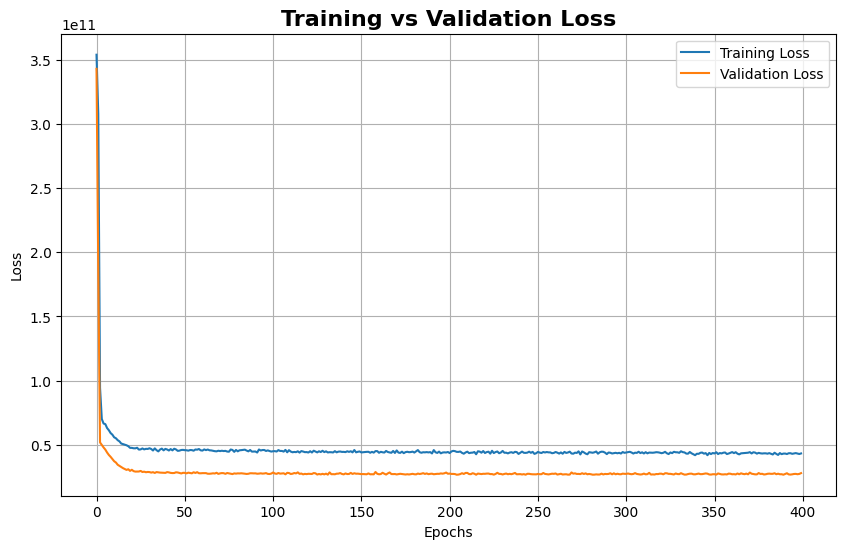

In [ ]:
# Преобразование истории обучения в DataFrame
losses2 = pd.DataFrame(history2.history)

# Визуализация функции потерь
plt.figure(figsize=(10,6))
plt.plot(losses2['loss'], label='Training Loss')
plt.plot(losses2['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.grid(True)
plt.show()

In [ ]:
# Выполнение предсказаний на тестовых данных
predictions2 = model2.predict(X_test2)

# Оценка метрик
mae2 = mean_absolute_error(y_test2, predictions2)
rmse2 = mean_squared_error(y_test2, predictions2, squared=False)
mape2 = mean_absolute_percentage_error(y_test2, predictions2)

print(f'MAPE: {mape2}')
print(f'MAE: {mae2}')
print(f'RMSE: {rmse2}')
r2 = r2_score(y_test2, predictions2.flatten())
print(f'R^2: {r2}')

201/201 [==============================] - 1s 5ms/step
MAPE: 0.20650205036771682
MAE: 109197.50269539157
RMSE: 166796.02088229917
R^2: 0.6462898541402153


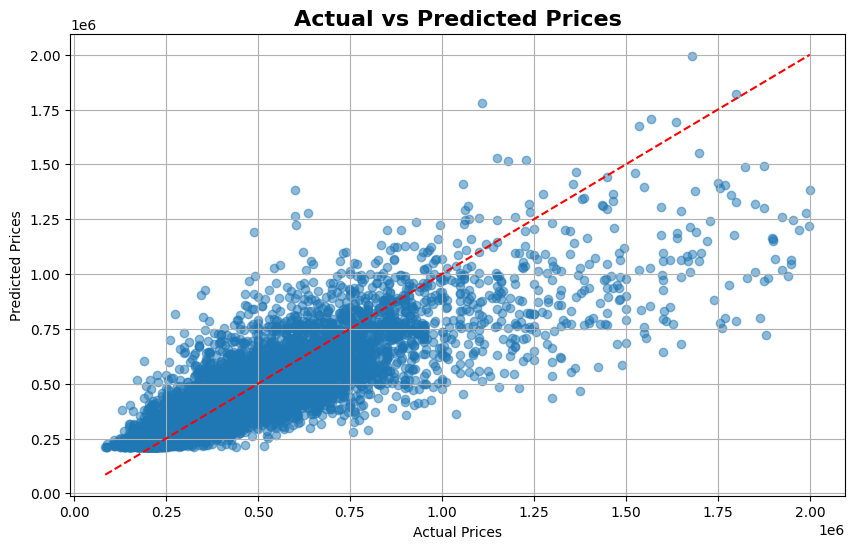

In [ ]:
# Визуализация предсказаний против фактических значений
plt.figure(figsize=(10,6))
plt.scatter(y_test2, predictions2, alpha=0.5)
plt.plot([min(y_test2), max(y_test2)], [min(y_test2), max(y_test2)], color='red', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.grid(True)
plt.show()

In [ ]:
data_to_test=df_n.iloc[0].drop('price').values

In [ ]:
data_to_test=data_to_test.reshape(-1,13)

In [ ]:
data_to_test=scaler.transform(data_to_test)

In [ ]:
model2.predict(data_to_test)

1/1 [==============================] - 0s 20ms/step


array([[255058.31]], dtype=float32)

 ## Пример 2

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

Сделаем тоже самое,что и в прошлых моделях:Подготовка признаков и целевой переменной,Определение категориальных столбцов,Кодирование категориальных переменных и масштабирование данных

In [ ]:

X = df.copy()
X.drop(['Адрес', 'Ссылка', 'Цена'], axis=1, inplace=True)
y = df['Цена']


categorical_columns = X.select_dtypes(include=['object']).columns

# Предполагая, что X и categorical_columns уже определены
onehot_encoder = OneHotEncoder(drop='first')
# Применяем OneHotEncoder
X_encoded_sparse = onehot_encoder.fit_transform(X[categorical_columns])
# Преобразуем в плотный массив
X_encoded = X_encoded_sparse.toarray()

# Удаление оригинальных категориальных столбцов из X
X = X.drop(categorical_columns, axis=1)
# Создаем DataFrame из X_encoded для добавления имен столбцов
X_encoded_df = pd.DataFrame(X_encoded, columns=onehot_encoder.get_feature_names_out(categorical_columns))

# Объединяем X с новыми One-Hot закодированными столбцами
X = pd.concat([X.reset_index(drop=True), X_encoded_df.reset_index(drop=True)], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)


scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
print(X.head())

   Минут до метро  Количество комнат  Площадь  Кухня площадь  Этаж  \
0             6.0                1.0     30.6            8.5  25.0   
1             2.0                1.0     49.2           10.0   6.0   
2            14.0                1.0     44.7           13.1  10.0   
3             8.0                1.0     35.1           11.0  12.0   
4             6.0                1.0     37.7            4.0   5.0   

   Количество этажей  Тип квартиры_Новостройка  Станция метро_автозаводская  \
0                 25                       0.0                          0.0   
1                 15                       0.0                          0.0   
2                 25                       0.0                          0.0   
3                 33                       0.0                          0.0   
4                  5                       0.0                          0.0   

   Станция метро_академическая  Станция метро_александровский сад  ...  \
0                          0.0

# Создание модели

Epoch 1/1000
239/239 [==============================] - 3s 7ms/step - loss: 6800907303911424.0000 - val_loss: 6901584558555136.0000
Epoch 2/1000
239/239 [==============================] - 1s 5ms/step - loss: 5001647256240128.0000 - val_loss: 4914389626912768.0000
Epoch 3/1000
239/239 [==============================] - 5s 20ms/step - loss: 3735584849788928.0000 - val_loss: 4138337354907648.0000
Epoch 4/1000
239/239 [==============================] - 1s 6ms/step - loss: 3186770975916032.0000 - val_loss: 3620314370015232.0000
Epoch 5/1000
239/239 [==============================] - 1s 5ms/step - loss: 2704759144316928.0000 - val_loss: 3159405591789568.0000
Epoch 6/1000
239/239 [==============================] - 1s 6ms/step - loss: 2372027491024896.0000 - val_loss: 2827546622164992.0000
Epoch 7/1000
239/239 [==============================] - 1s 5ms/step - loss: 2215936299892736.0000 - val_loss: 2637612699353088.0000
Epoch 8/1000
239/239 [==============================] - 1s 5ms/step - loss:

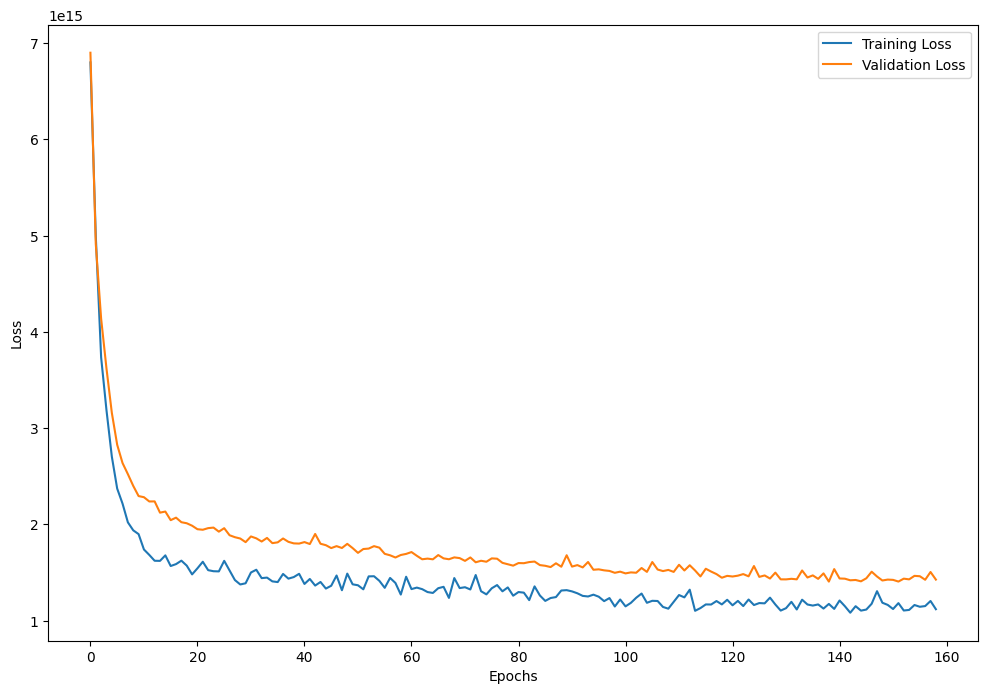

In [ ]:
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))


model.compile(optimizer='adam', loss='mse')

# Определение раннего прекращения обучения
# early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Обучение модели
history = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), batch_size=64, epochs=1000, callbacks=[early_stopping])

# Оценка модели на тестовых данных
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Визуализация функции потерь
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

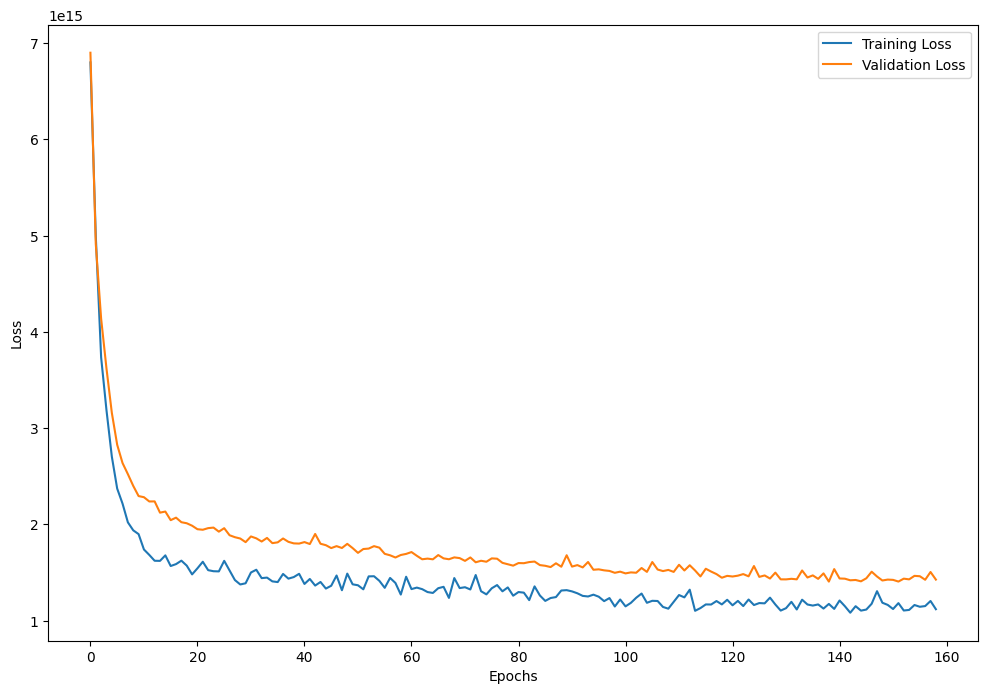

In [ ]:
# Визуализация функции потерь
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

В данном случае мы рассмотрим график, на котором отображены значения функции потерь для обучающей и валидационной выборок на протяжении всех эпох.

##**Выводы:**
###*Training Loss:* Значения функции потерь на обучающих данных немного ниже.
###*Validation Loss:* Значения функции потерь на валидационных данных немного выше.
###*Нижее значение Training Loss:* Указывает на то, что модель хорошо обучается на обучающих данных.
###*Чуть вышее значение Validation Loss:* Указывает на то, что модель также хорошо обобщает на валидационных данных, но есть небольшое увеличение ошибки по сравнению с обучающими данными.
###*Отсутствие переобучения:*
###Маленькая разница между Training Loss и Validation Loss: Указывает на то, что модель не переобучена и хорошо обобщает на новых данных. Это хороший знак, так как модель не запоминает обучающие данные, а действительно учится на них.
###*Постепенное снижение функции потерь:*
### Снижение функции потерь: Указывает на то, что модель постепенно улучшает свои предсказания как на обучающих, так и на валидационных данных в процессе обучения.

In [ ]:
predictions=model.predict(X_test)

205/205 [==============================] - 0s 2ms/step


In [ ]:

# Оценка метрик
mae = mean_absolute_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
mape = mean_absolute_percentage_error(y_test, predictions)
r2 = r2_score(y_test, predictions.flatten())
print(f'MAPE: {mape}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse2}')
print(f'R^2: {r2}')

MAPE: 0.24458304955648275
MAE: 9467205.192160757
RMSE: 166796.02088229917
R^2: 0.7888271750716896


In [ ]:
explained_variance_score(y_test,predictions)

0.7888295127731786

Вывод:Explained Variance Score измеряет долю дисперсии, объясненную моделью. Значение близкое к 1 указывает на то, что модель хорошо объясняет дисперсию данных. Значение 0.8104137211568205 указывает на то, что модель объясняет около 81% дисперсии данных, что является хорошим показателем

## Замена выбросов в наборе данных

Произведен такую же замену выбросов,как делали до этого

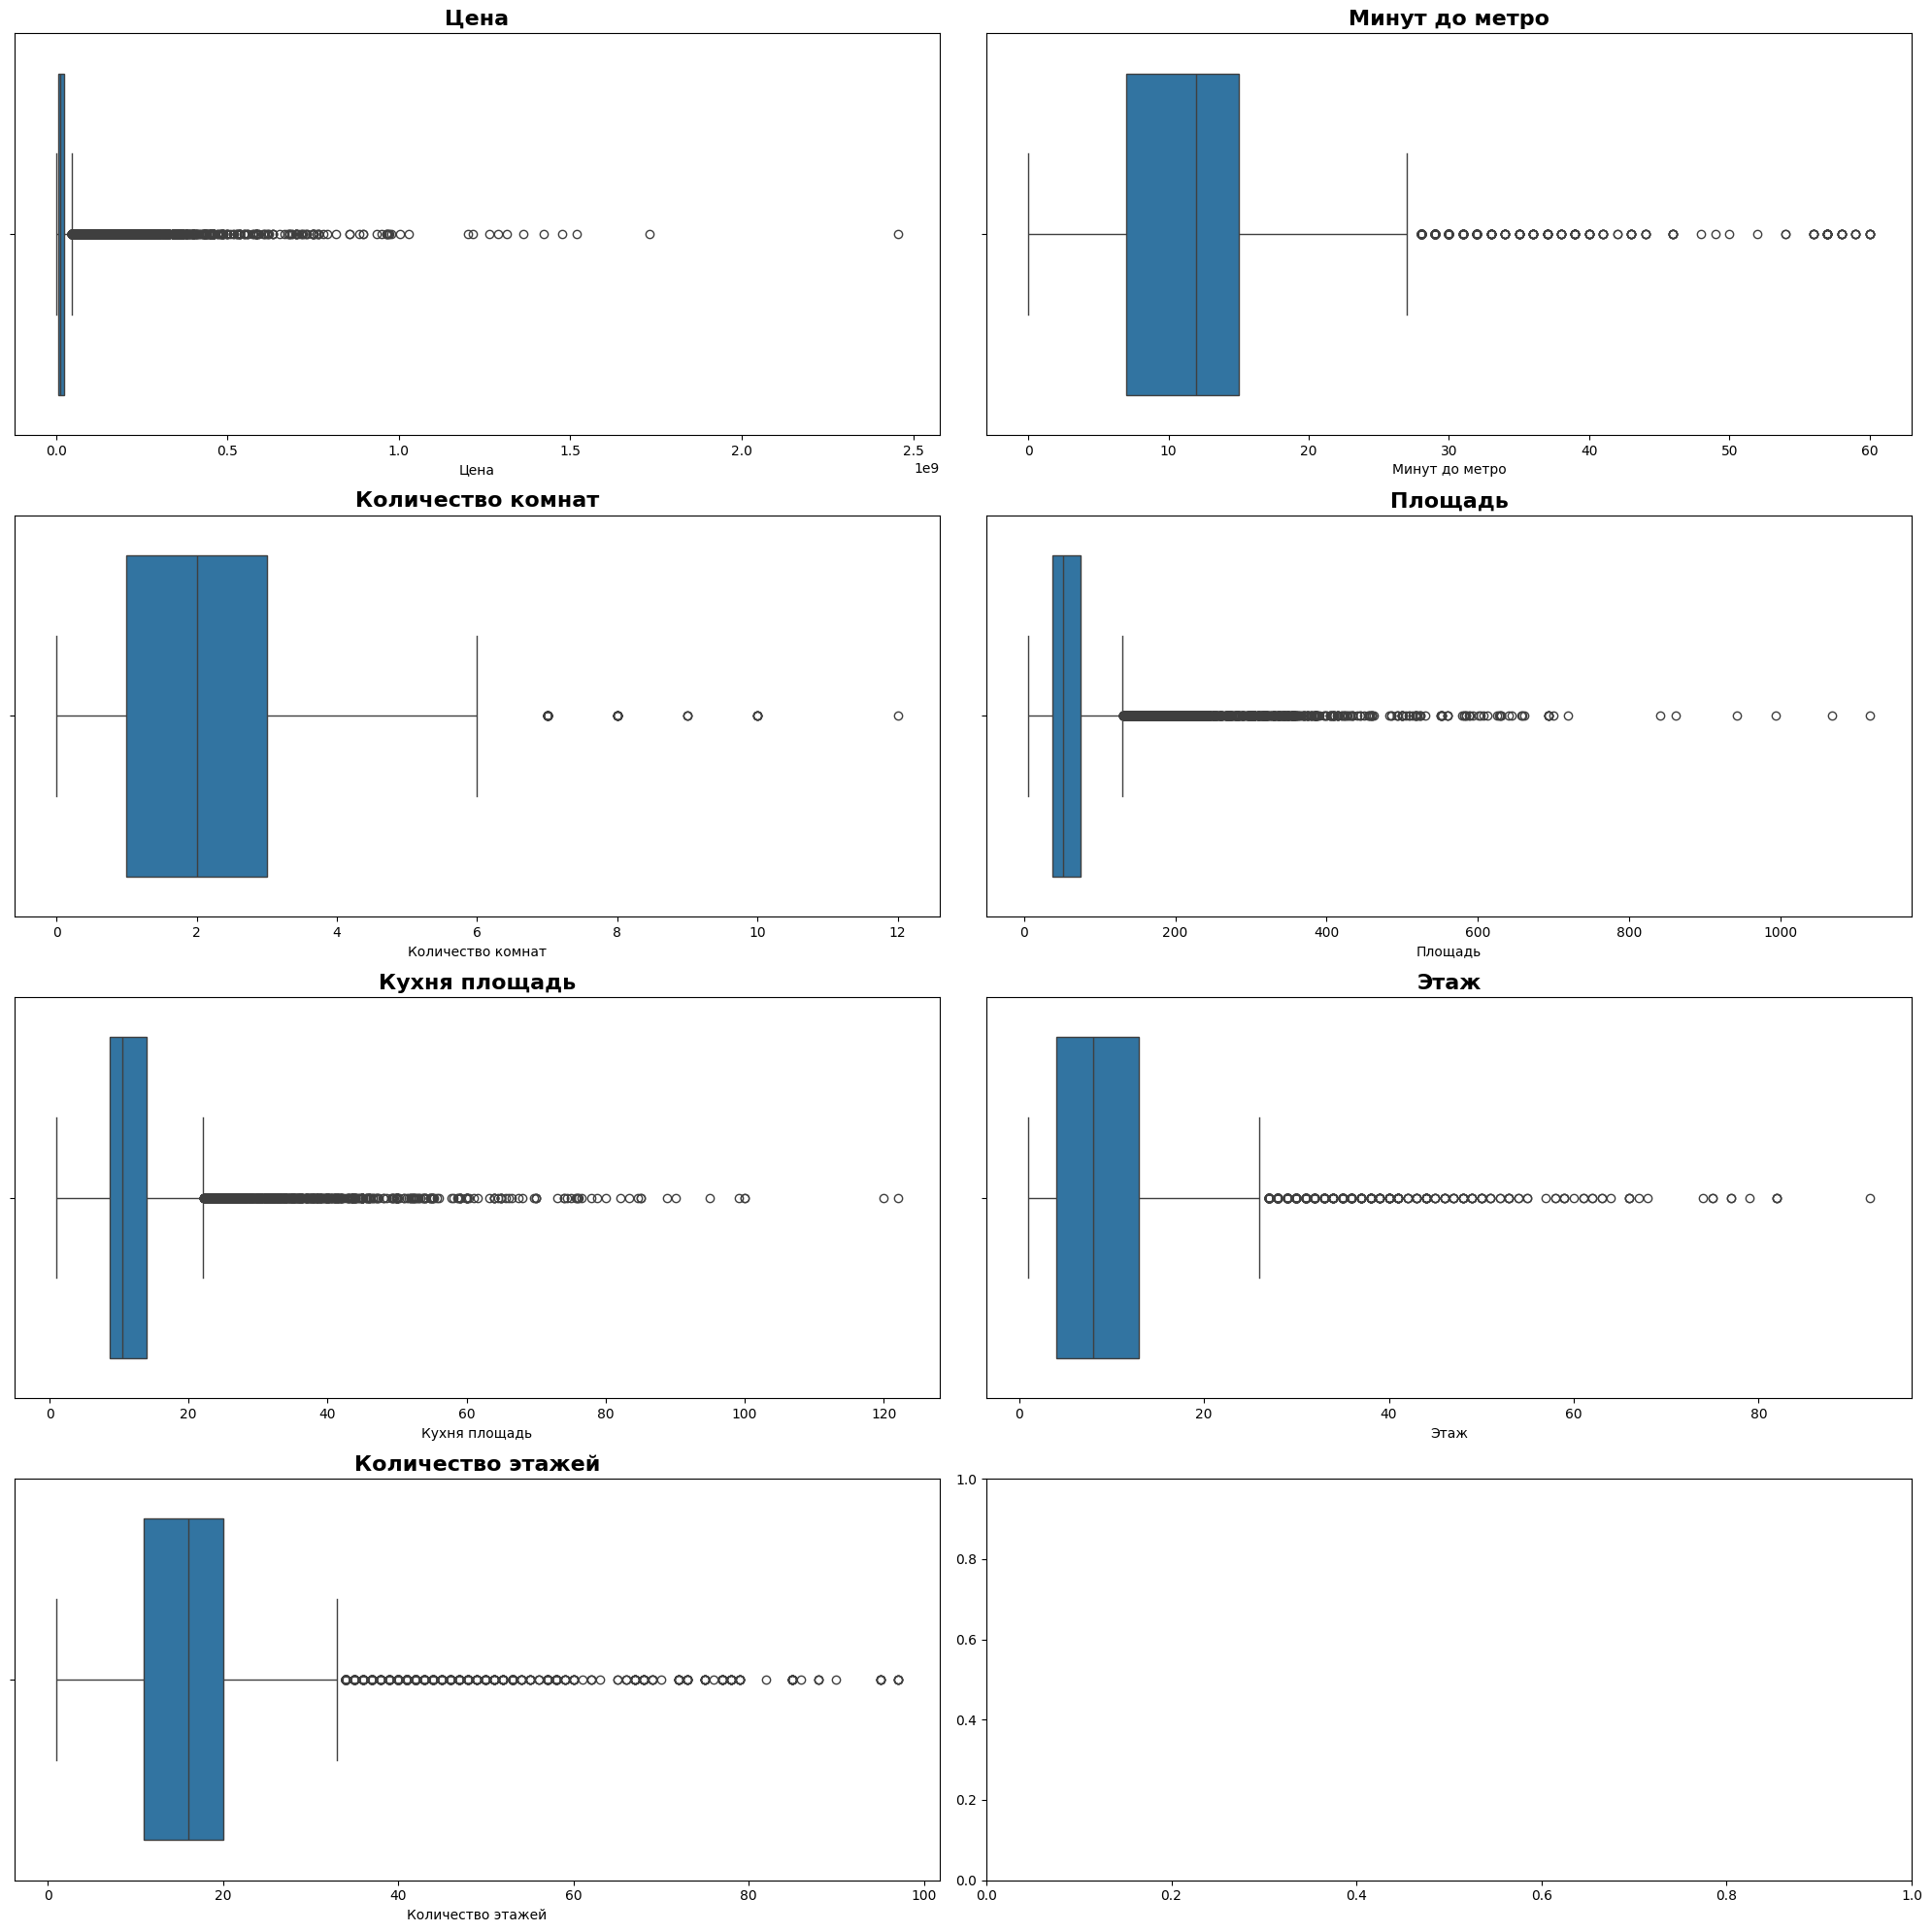

In [ ]:
numeric_lst = list(df.select_dtypes(include = ['float64', 'int64']).columns)

fig, axes = plt.subplots(4,2, figsize = (20,20))

for i, n in enumerate(numeric_lst):
    ax = axes[i // 2,i % 2]
    sns.boxplot(data = df,
                x = n,
                ax = ax)
    ax.set_title(n)

plt.tight_layout()
plt.show()

In [ ]:
# Создаем список со значениями, где надо заменить выбросы
emissions = df.select_dtypes(include = ['float64', 'int64'])
emissions.drop('Количество комнат', axis = 1, inplace = True)
emissions_lst = list(emissions.columns)
emissions_lst

['Цена',
 'Минут до метро',
 'Площадь',
 'Кухня площадь',
 'Этаж',
 'Количество этажей']

In [ ]:
X = df[['Цена', 'Тип квартиры', 'Станция метро', 'Минут до метро', 'Регион',
        'Количество комнат', 'Площадь', 'Кухня площадь', 'Этаж', 'Количество этажей', 'Ремонт']]


In [ ]:
def iqr_replacement(data, list_replace):

    # Замена выбросов на медианное значение
    for l in list_replace:
        q1 = data[l].quantile(0.25)
        q3 = data[l].quantile(0.75)

        iqr = q3 - q1

        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        data[l] = data[l].apply(lambda x: data[l].median() if x < lower_bound or x > upper_bound else x)

    return data

In [ ]:
X = iqr_replacement(X, emissions_lst)


<ipython-input-156-9508362b8717>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[l] = data[l].apply(lambda x: data[l].median() if x < lower_bound or x > upper_bound else x)
<ipython-input-156-9508362b8717>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[l] = data[l].apply(lambda x: data[l].median() if x < lower_bound or x > upper_bound else x)
<ipython-input-156-9508362b8717>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

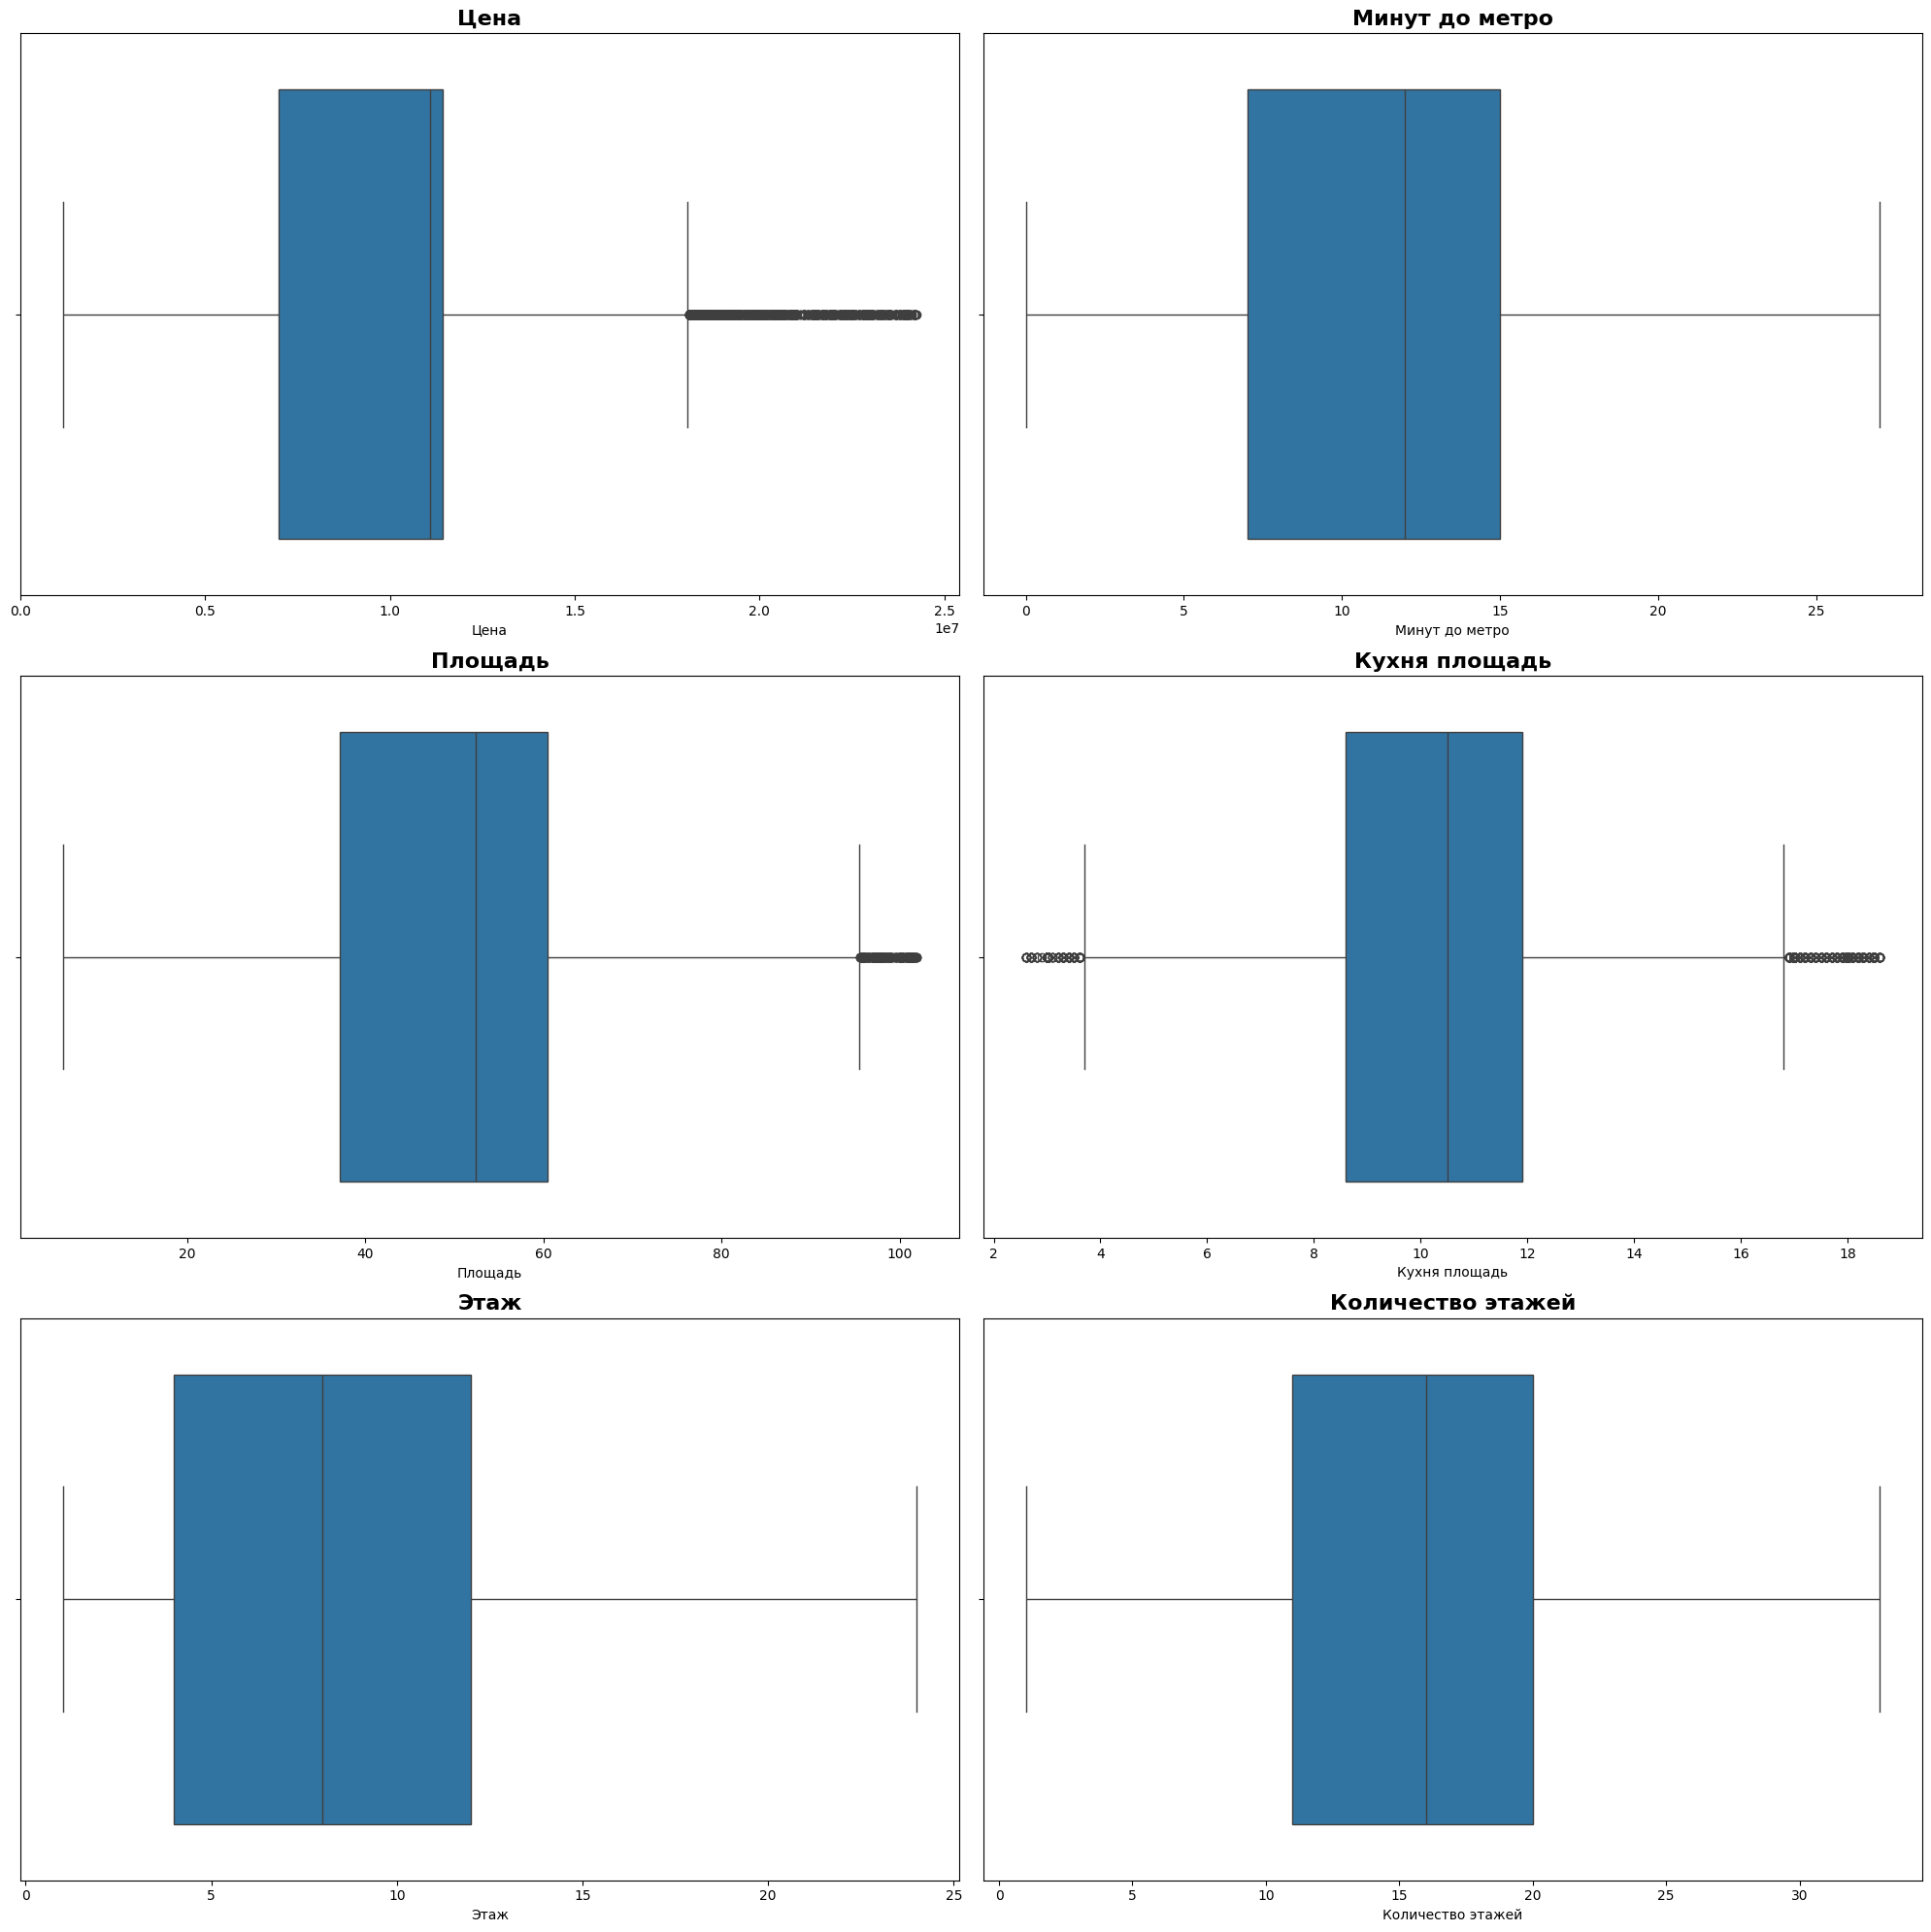

In [ ]:
fig, axes = plt.subplots(3,2, figsize = (20,20))

for i, n in enumerate(emissions_lst):
    ax = axes[i // 2, i % 2]
    sns.boxplot(data = X,
                x = n,
                ax = ax)
    ax.set_title(n)

plt.tight_layout()
plt.show()

In [ ]:
data = X.copy()


In [ ]:
# Данные для обучения
y = data['Цена']
X = data.drop('Цена', axis = 1)

In [ ]:
# Столбцы которые будем кодировать
encoder = ['Тип квартиры', 'Регион', 'Ремонт']

for e in encoder:
    X = pd.get_dummies(X, columns=[e])
dummies = list(X.columns[7:])
X[dummies] = X[dummies].astype(int)
X.head(3)

,Станция метро,Минут до метро,Количество комнат,Площадь,Кухня площадь,Этаж,Количество этажей,Тип квартиры_Вторичное,Тип квартиры_Новостройка,Регион_Москва,Регион_Московская область,Ремонт_Без ремонта,Ремонт_Дизайнерский,Ремонт_Евроремонт,Ремонт_Косметический
0,опалиха,6.0,1.0,30.6,8.5,8.0,25.0,1,0,0,1,0,0,0,1
1,павшино,2.0,1.0,49.2,10.0,6.0,15.0,1,0,0,1,0,0,1,0
2,мякинино,14.0,1.0,44.7,13.1,10.0,25.0,1,0,0,1,0,0,0,1


In [ ]:
label_encoder = LabelEncoder()

# Кодируем
X['Станция метро'] = label_encoder.fit_transform(X['Станция метро'])

In [ ]:
X.head(3)

In [ ]:

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Масштабирование данных
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Создание модели
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

# Компиляция модели
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Определение раннего прекращения обучения
#early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Обучение модели
history = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), batch_size=64, epochs=500, callbacks=[early_stopping])

# Оценка модели на тестовых данных
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

Epoch 1/500
239/239 [==============================] - 2s 5ms/step - loss: 89683522486272.0000 - val_loss: 14688236601344.0000
Epoch 2/500
239/239 [==============================] - 1s 5ms/step - loss: 18218253025280.0000 - val_loss: 12207836364800.0000
Epoch 3/500
239/239 [==============================] - 2s 6ms/step - loss: 16931724722176.0000 - val_loss: 12059491172352.0000
Epoch 4/500
239/239 [==============================] - 2s 6ms/step - loss: 16153219956736.0000 - val_loss: 10714626392064.0000
Epoch 5/500
239/239 [==============================] - 1s 4ms/step - loss: 15837532520448.0000 - val_loss: 10810666516480.0000
Epoch 6/500
239/239 [==============================] - 1s 4ms/step - loss: 15577060999168.0000 - val_loss: 10485605859328.0000
Epoch 7/500
239/239 [==============================] - 1s 4ms/step - loss: 15318205333504.0000 - val_loss: 10282349887488.0000
Epoch 8/500
239/239 [==============================] - 1s 4ms/step - loss: 15218460590080.0000 - val_loss: 1027

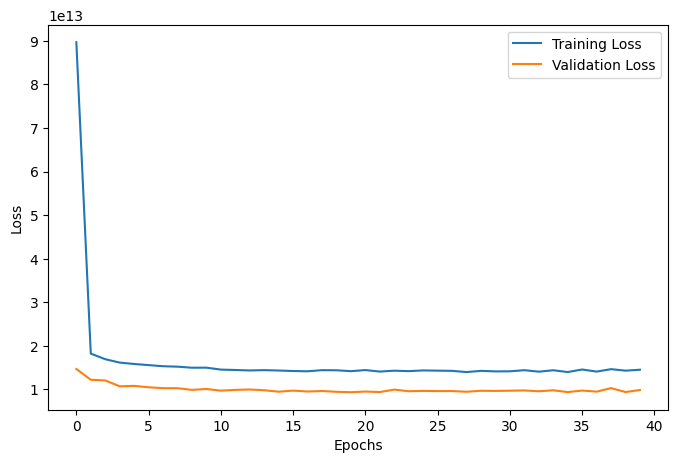

In [ ]:
# Визуализация функции потерь
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Выполнение предсказаний на тестовых данных
predictions = model.predict(X_test)

205/205 [==============================] - 0s 2ms/step


In [ ]:
# Вычисление метрик
mae = mean_absolute_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
mape = mean_absolute_percentage_error(y_test, predictions)
r2 = r2_score(y_test, predictions.flatten())

# Вывод метрик
print(f'MAPE: {mape}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

MAPE: 0.203349683115568
MAE: 2067115.1685131418
RMSE: 3058229.9694101196
R^2: 0.5068771969762336


### **Вывод на новом наборе:**
 Обе функции потерь снижаются, что указывает на улучшение производительности модели как на обучающих, так и на валидационных данных.

Текущая модель имеет меньшую среднюю абсолютную ошибку по сравнению с предыдущей моделью, что свидетельствует о повышении точности предсказаний

Модель демонстрирует хорошую способность к обобщению, так как разница между функцией потерь на обучающих и валидационных данных минимальна.

## Пример 3

In [ ]:
import pandas as pd
import numpy as np
import csv

# Чтение данных с использованием кодировки 'cp1251' и параметра on_bad_lines
data = pd.read_csv('realty.csv', sep=';', encoding='cp1251', header=0,
                   names=['price','price_per_m','title','okrug','district',
                          'address','transport','square','live_square',
                          'kitchen_square','etage','year','room_sq','height',
                          'sanuzel','balcon','view','otdelka'],
                   quoting=csv.QUOTE_NONE, on_bad_lines='skip')

# Удаление дубликатов
data = data.drop_duplicates(keep='first')

# Замена значений 'None' на NaN и заполнение NaN значением '0'
data = data.replace(['None'], [np.nan]).fillna('0')

# Проверка наличия столбцов
print(data.columns)

# Проверка первых нескольких строк данных
print(data.head())

Index(['price', 'price_per_m', 'title', 'okrug', 'district', 'address',
       'transport', 'square', 'live_square', 'kitchen_square', 'etage', 'year',
       'room_sq', 'height', 'sanuzel', 'balcon', 'view', 'otdelka'],
      dtype='object')
      price  price_per_m             title okrug             district  \
0  16500000       257813  3-комн. квартира   САО         р-н Аэропорт   
1  18500000       330357  2-комн. квартира   САО         р-н Аэропорт   
2  21000000       257353  4-комн. квартира   ЦАО   р-н Красносельский   
3  18000000       300000  2-комн. квартира   ЦАО   р-н Красносельский   
4  18500000       283742  3-комн. квартира   ЦАО   р-н Красносельский   

                        address                      transport square  \
0   1-й Амбулаторный проезд 7К3        Аэропорт 16 мин. пешком     64   
1   1-й Амбулаторный проезд 7кБ           Сокол 14 мин. пешком     56   
2     1-й Басманный пер. 5/20С1   Комсомольская 10 мин. пешком   81,6   
3     1-й Басманный пер. 5

In [ ]:
data.head()

,price,price_per_m,title,okrug,district,address,transport,square,live_square,kitchen_square,etage,year,room_sq,height,sanuzel,balcon,view,otdelka
0,16500000,257813,3-комн. квартира,САО,р-н Аэропорт,1-й Амбулаторный проезд 7К3,Аэропорт 16 мин. пешком,64,"43,7","7,1",6 из 12,1974.0,"16-14,8-12,9","2,64 м",1 раздельный,2 балкона,во двор,косметический
1,18500000,330357,2-комн. квартира,САО,р-н Аэропорт,1-й Амбулаторный проезд 7кБ,Сокол 14 мин. пешком,56,"35,5",8,5 из 5,1958.0,0,0,1 совмещенный,1 балкон,во двор,косметический
2,21000000,257353,4-комн. квартира,ЦАО,р-н Красносельский,1-й Басманный пер. 5/20С1,Комсомольская 10 мин. пешком,"81,6","58,2",9,5 из 5,1927.0,"12,7+12,3+26,4+6,8","2,95 м",1 раздельный,1 балкон,0,косметический
3,18000000,300000,2-комн. квартира,ЦАО,р-н Красносельский,1-й Басманный пер. 5/20С2,Комсомольская 10 мин. пешком,60,37,8,2 из 6,1927.0,15-22,0,2 совмещенных,1 балкон,во двор,косметический
4,18500000,283742,3-комн. квартира,ЦАО,р-н Красносельский,1-й Басманный пер. 5/20С3,Красные ворота 10 мин. пешком,"65,2","44,3","8,3",3 из 5,1927.0,16.8-16.2-11.3,3 м,1 раздельный,0,на улицу и двор,без ремонта


In [ ]:

# Функции для обработки данных
def get_transport_time(s):
    ans = ''
    ind = s.find(' мин.')
    ans += s[ind-1]
    if s[ind-2] != " ":
        ans += s[ind-2]
    if 'транспорт' in s:
        return 6*int(ans[::-1]) # если время было указано на транспорте - умножим его на 6
    else:
        return int(ans[::-1])

def get_station_name(s):
    ans = ''
    ind = s.find(' мин.')-1 # крайняя цифра
    if s[ind-1] != " ": # если еще одна цифра
        ans += s[:ind-2]
    else:
        ans += s[:ind-1]
    return ans

# Обработка данных
data['all_etage'] = data['etage'].apply(lambda x: x.split()[2] if x != '0' else x).astype(int)
data['etage'] = data['etage'].apply(lambda x: x.split()[0]).astype(int)
data['square'] = data['square'].replace(',','.', regex=True).astype(float)
data['live_square'] = data['live_square'].replace(',','.', regex=True).astype(float)
data['kitchen_square'] = data['kitchen_square'].replace(',','.', regex=True).astype(float)
data['height'] = data['height'].replace(',','.', regex=True).apply(lambda x: x.split()[0]).astype(float)
data['year'] = data['year'].astype(float).astype(int)
data['station'] = data['transport'].apply(get_station_name)
data['transport_time'] = data['transport'].apply(get_transport_time)

print(data.head())

      price  price_per_m             title okrug             district  \
0  16500000       257813  3-комн. квартира   САО         р-н Аэропорт   
1  18500000       330357  2-комн. квартира   САО         р-н Аэропорт   
2  21000000       257353  4-комн. квартира   ЦАО   р-н Красносельский   
3  18000000       300000  2-комн. квартира   ЦАО   р-н Красносельский   
4  18500000       283742  3-комн. квартира   ЦАО   р-н Красносельский   

                        address                      transport  square  \
0   1-й Амбулаторный проезд 7К3        Аэропорт 16 мин. пешком    64.0   
1   1-й Амбулаторный проезд 7кБ           Сокол 14 мин. пешком    56.0   
2     1-й Басманный пер. 5/20С1   Комсомольская 10 мин. пешком    81.6   
3     1-й Басманный пер. 5/20С2   Комсомольская 10 мин. пешком    60.0   
4     1-й Басманный пер. 5/20С3  Красные ворота 10 мин. пешком    65.2   

   live_square  kitchen_square  ...  year             room_sq height  \
0         43.7             7.1  ...  1974   


address - бесполезен, тк является категориальным и принимает слишком много разных значений.


In [ ]:
del data['price_per_m']
del data['address']
del data['transport']
del data['room_sq']

In [ ]:
data.head()

,price,title,okrug,district,square,live_square,kitchen_square,etage,year,height,sanuzel,balcon,view,otdelka,all_etage,station,transport_time
0,16500000,3-комн. квартира,САО,р-н Аэропорт,64.0,43.7,7.1,6,1974,2.64,1 раздельный,2 балкона,во двор,косметический,12,Аэропорт,16
1,18500000,2-комн. квартира,САО,р-н Аэропорт,56.0,35.5,8.0,5,1958,0.00,1 совмещенный,1 балкон,во двор,косметический,5,Сокол,14
2,21000000,4-комн. квартира,ЦАО,р-н Красносельский,81.6,58.2,9.0,5,1927,2.95,1 раздельный,1 балкон,0,косметический,5,Комсомольская,10
3,18000000,2-комн. квартира,ЦАО,р-н Красносельский,60.0,37.0,8.0,2,1927,0.00,2 совмещенных,1 балкон,во двор,косметический,6,Комсомольская,10
4,18500000,3-комн. квартира,ЦАО,р-н Красносельский,65.2,44.3,8.3,3,1927,3.00,1 раздельный,0,на улицу и двор,без ремонта,5,Красные ворота,10


Обратим внимание, что многие признаки являются категориальными и что для дальнейшего обучения их необходимо спроецировать в область вещественных значений. Для этого воспользуемся встроенным в библиотеку sklearn кодировщиком LabelEncoder().

In [ ]:
features = ['title','okrug','district','sanuzel','balcon','view',
            'otdelka','station']
data_encoded = data.copy(deep=True)

def feature_encoding(data, features):
    le = LabelEncoder()
    for feature in features:
        le.fit(data[feature])
        data[feature] = le.transform(data[feature])
    return data

data_encoded = feature_encoding(data_encoded, features)
data_encoded.head()

,price,title,okrug,district,square,live_square,kitchen_square,etage,year,height,sanuzel,balcon,view,otdelka,all_etage,station,transport_time
0,16500000,5,3,9,64.0,43.7,7.1,6,1974,2.64,1,5,1,4,12,6,16
1,18500000,3,3,9,56.0,35.5,8.0,5,1958,0.00,2,1,1,4,5,136,14
2,21000000,7,6,30,81.6,58.2,9.0,5,1927,2.95,1,1,0,4,5,58,10
3,18000000,3,6,30,60.0,37.0,8.0,2,1927,0.00,7,1,1,4,6,58,10
4,18500000,5,6,30,65.2,44.3,8.3,3,1927,3.00,1,0,3,1,5,62,10


In [ ]:
print(data.columns)

Index(['price', 'title', 'okrug', 'district', 'square', 'live_square',
       'kitchen_square', 'etage', 'year', 'height', 'sanuzel', 'balcon',
       'view', 'otdelka', 'all_etage', 'station', 'transport_time'],
      dtype='object')


In [ ]:
# Кодирование категориальных переменных
label_encoders = {}
for col in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

In [ ]:
# Разделение данных на признаки (X) и целевую переменную (y)
X = data.drop('price', axis=1).values
y = data['price'].values

In [ ]:
# Масштабирование данных
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [ ]:

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Создание модели
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

# Компиляция модели
model.compile(optimizer='adam', loss='mse')

# Определение раннего прекращения обучения
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Обучение модели
history = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), batch_size=64, epochs=1000, callbacks=[early_stopping])

Epoch 1/1000
26/26 [==============================] - 2s 21ms/step - loss: 473737208004608.0000 - val_loss: 434372423450624.0000
Epoch 2/1000
26/26 [==============================] - 0s 8ms/step - loss: 473733651234816.0000 - val_loss: 434357357510656.0000
Epoch 3/1000
26/26 [==============================] - 0s 10ms/step - loss: 473631779979264.0000 - val_loss: 434026947018752.0000
Epoch 4/1000
26/26 [==============================] - 0s 9ms/step - loss: 472343692443648.0000 - val_loss: 430662444122112.0000
Epoch 5/1000
26/26 [==============================] - 0s 9ms/step - loss: 462694410878976.0000 - val_loss: 410829392445440.0000
Epoch 6/1000
26/26 [==============================] - 0s 10ms/step - loss: 419874492907520.0000 - val_loss: 336661649031168.0000
Epoch 7/1000
26/26 [==============================] - 0s 8ms/step - loss: 297897891463168.0000 - val_loss: 178334172446720.0000
Epoch 8/1000
26/26 [==============================] - 0s 6ms/step - loss: 153591067181056.0000 - val_

In [ ]:
# Выполнение предсказаний на тестовых данных
predictions = model.predict(X_test)

# Оценка метрик
mae = mean_absolute_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
mape = mean_absolute_percentage_error(y_test, predictions)
r2 = r2_score(y_test, predictions.flatten())

print(f'MAPE: {mape}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

22/22 [==============================] - 0s 2ms/step
MAPE: 0.17814643414724152
MAE: 3056333.2661174787
RMSE: 4382694.094799168
R^2: 0.8391932336585132


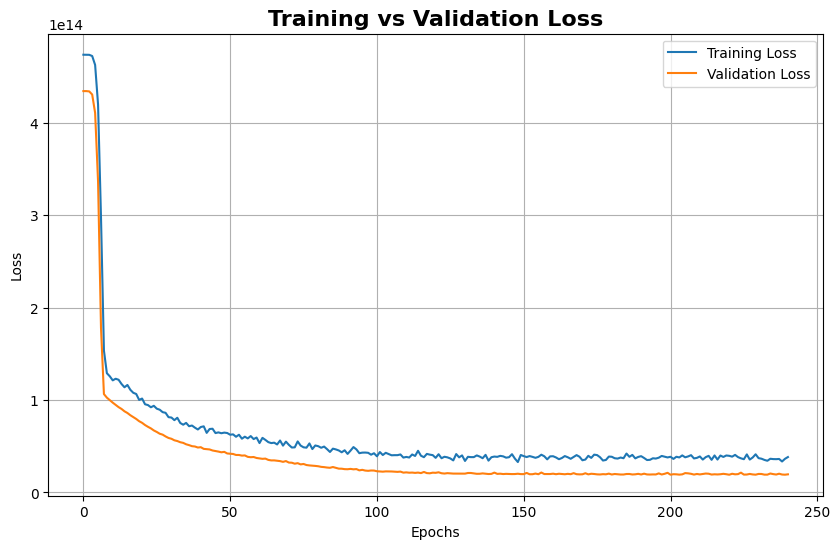

In [ ]:
# Визуализация функции потерь
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.grid(True)
plt.show()

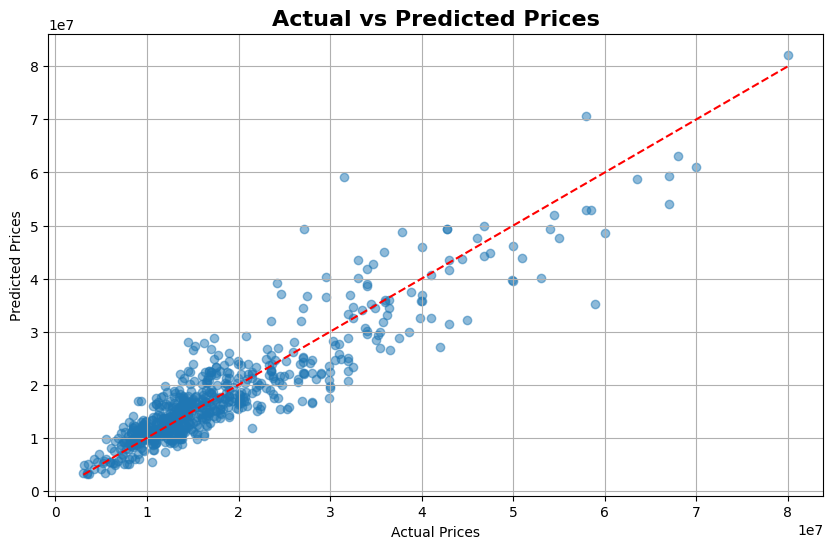

In [ ]:
#о предсказания и фактические значения имеют одинаковую длину
assert len(predictions) == len(y_test)

# Визуализация предсказаний против фактических значений
plt.figure(figsize=(10,6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.grid(True)
plt.show()

## V.2

In [ ]:

# Чтение данных с использованием кодировки 'cp1251' и параметра on_bad_lines
data2 = pd.read_csv('data2.csv', sep=';', encoding='cp1251', header=0,
                   names=['price','price_per_m','title','okrug','district',
                          'address','transport','square','live_square',
                          'kitchen_square','etage','year','room_sq','height',
                          'sanuzel','balcon','view','otdelka'],
                   quoting=csv.QUOTE_NONE, on_bad_lines='skip')



# Удаление дубликатов
data2 = data2.drop_duplicates(keep='first')

# Замена значений 'None' на NaN и заполнение NaN значением '0'
data2 = data2.replace(['None'], [np.nan]).fillna('0')



In [ ]:
# Функции для обработки данных
def get_transport_time(s):
    ans = ''
    ind = s.find(' мин.')
    ans += s[ind-1]
    if s[ind-2] != " ":
        ans += s[ind-2]
    if 'транспорт' in s:
        return 6*int(ans[::-1]) # если время было указано на транспорте - умножим его на 6
    else:
        return int(ans[::-1])

def get_station_name(s):
    ans = ''
    ind = s.find(' мин.')-1 # крайняя цифра
    if s[ind-1] != " ": # если еще одна цифра
        ans += s[:ind-2]
    else:
        ans += s[:ind-1]
    return ans

# Обработка данных
data2['all_etage'] = data2['etage'].apply(lambda x: x.split()[2] if x != '0' else x).astype(int)
data2['etage'] = data2['etage'].apply(lambda x: x.split()[0]).astype(int)
data2['square'] = data2['square'].replace(',','.', regex=True).astype(float)
data2['live_square'] = data2['live_square'].replace(',','.', regex=True).astype(float)
data2['kitchen_square'] = data2['kitchen_square'].replace(',','.', regex=True).astype(float)
data2['height'] = data2['height'].replace(',','.', regex=True).apply(lambda x: x.split()[0]).astype(float)
data2['year'] = data2['year'].astype(float).astype(int)
data2['station'] = data2['transport'].apply(get_station_name)
data2['transport_time'] = data2['transport'].apply(get_transport_time)

In [ ]:
del data2['price_per_m']
del data2['address']
del data2['transport']
del data2['room_sq']

In [ ]:
features = ['title','okrug','district','sanuzel','balcon','view',
            'otdelka','station']
data_encoded = data2.copy(deep=True)

def feature_encoding(data, features):
    le = LabelEncoder()
    for feature in features:
        le.fit(data[feature])
        data[feature] = le.transform(data[feature])
    return data

data_encoded = feature_encoding(data_encoded, features)
data_encoded.head()

,price,title,okrug,district,square,live_square,kitchen_square,etage,year,height,sanuzel,balcon,view,otdelka,all_etage,station,transport_time
0,16500000,5,3,9,64.0,43.7,7.1,6,1974,2.64,1,5,1,4,12,6,16
1,18500000,3,3,9,56.0,35.5,8.0,5,1958,0.00,2,1,1,4,5,136,14
2,21000000,7,6,30,81.6,58.2,9.0,5,1927,2.95,1,1,0,4,5,58,10
3,18000000,3,6,30,60.0,37.0,8.0,2,1927,0.00,7,1,1,4,6,58,10
4,18500000,5,6,30,65.2,44.3,8.3,3,1927,3.00,1,0,3,1,5,62,10


In [ ]:

# Кодирование категориальных переменных
label_encoders = {}
for col in data2.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data2[col] = le.fit_transform(data2[col])
    label_encoders[col] = le

# Разделение данных на признаки (X) и целевую переменную (y)
X = data2.drop('price', axis=1).values
y = data2['price'].values

# Масштабирование данных
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
data2.head()

In [ ]:
#def create_model(optimizer='adam', init='glorot_uniform'):
 #   model = Sequential()
  #  model.add(Dense(128, input_dim=X_train.shape[1], activation='relu', kernel_initializer=init))
   # model.add(Dropout(0.3))
    #model.add(Dense(128, activation='relu', kernel_initializer=init))
    #model.add(Dropout(0.3))
    #model.add(Dense(64, activation='relu', kernel_initializer=init))
    #model.add(Dropout(0.3))
    #model.add(Dense(64, activation='relu', kernel_initializer=init))
    #model.add(Dropout(0.3))
    #model.add(Dense(32, activation='relu', kernel_initializer=init))
    #model.add(Dropout(0.3))
    #model.add(Dense(1))
    #model.compile(optimizer=optimizer, loss='mse')
    #return model

In [ ]:


# Изменение функции create_model для включения нейронов и количества слоев
def create_model(neurons=128, hidden_layers=2, optimizer='adam', init='glorot_uniform'):
    model = Sequential()
    # Входной слой
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation='relu', kernel_initializer=init))
    model.add(Dropout(0.3))

    # Динамическое создание скрытых слоев
    for _ in range(hidden_layers):
        model.add(Dense(neurons, activation='relu', kernel_initializer=init))
        model.add(Dropout(0.3))

    # Выходной слой
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model


In [13]:

# Указание GridSearchCV для использования модифицированной функции create_model
model = KerasRegressor(build_fn=create_model, verbose=0)


param_grid = {
    'batch_size': [32, 64, 128],
    'epochs': [50, 100, 200,500],
    'optimizer': ['adam', 'rmsprop'],
    'init': ['glorot_uniform', 'normal', 'uniform'],
    'neurons': [32,64, 128, 256], # Эксперимент с различным количеством нейронов
    'hidden_layers': [1, 2, 3,4] # Эксперимент с различным количеством скрытых слоев
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# Вывод лучших гиперпараметров
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

<ipython-input-13-55c260219ae8>:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
#!pip install keras==2.12.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.12.0 which is incompatible.


In [ ]:
#!pip uninstall tensorflow
#!pip install tensorflow==2.12.0


In [ ]:
#!pip install scikeras

from scikeras.wrappers import KerasClassifier

In [ ]:
#!pip install scikeras==0.12.0

  Attempting uninstall: scikeras
    Found existing installation: scikeras 0.13.0
    Uninstalling scikeras-0.13.0:
      Successfully uninstalled scikeras-0.13.0


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor

In [ ]:
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [ ]:
#model = KerasRegressor(build_fn=create_model, verbose=0)

# Определение гиперпараметров для Grid Search
#param_grid = {
 #   'batch_size': [32, 64, 128],
  #  'epochs': [50, 100, 200],
   # 'optimizer': ['adam', 'rmsprop'],
    #'init': ['glorot_uniform', 'normal', 'uniform']
#}

#grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
#grid_result = grid.fit(X_train, y_train)

# Вывод лучших гиперпараметров
#print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

<ipython-input-11-a239211561fa>:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


KeyboardInterrupt: 

In [ ]:
# Извлекаем наилучшие параметры
best_params = grid_result.best_params_

# Создаем модель с наилучшими параметрами
final_model = create_model(
    neurons=best_params['neurons'],
    hidden_layers=best_params['hidden_layers'],
    optimizer=best_params['optimizer'],
    init=best_params['init']
)

# Обучаем модель
final_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)


In [ ]:
# Создание модели с лучшими гиперпараметрами
#model2 = create_model(optimizer=grid_result.best_params_['optimizer'], init=grid_result.best_params_['init'])

# Определение раннего прекращения обучения
#early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Обучение модели
#history2 = model2.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), batch_size=grid_result.best_params_['batch_size'], epochs=grid_result.best_params_['epochs'], callbacks=[early_stopping])

In [ ]:
# Выполнение предсказаний на тестовых данных
predictions2 = model2.predict(X_test)

# Оценка метрик
mae2 = mean_absolute_error(y_test, predictions2)
rmse2 = mean_squared_error(y_test, predictions2, squared=False)
mape2 = mean_absolute_percentage_error(y_test, predictions2)

print(f'MAPE: {mape2}')
print(f'MAE: {mae2}')
print(f'RMSE: {rmse2}')

# Визуализация функции потерь
plt.figure(figsize=(10,6))
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.grid(True)
plt.show()

# Визуализация предсказаний против фактических значений
plt.figure(figsize=(10,6))
plt.scatter(y_test, predictions2, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.grid(True)
plt.show()

### Сохранение модели

In [ ]:
 #from tensorflow.keras.models import load_model

# Сохранение лучшей модели в формате HDF5
#best_model = grid_result.best_estimator_.model
#best_model.save("best_model.h5")


# Заключение


Цель работы — предсказание стоимости коттеджа по его площади и другим характеристик.

Использованные пакеты: numpy,pandas,matplotlib,seaborn,sklearn (scikit-learn),statsmodels,catboost,tensorflow,keras,graphviz,warnings.

В ходе данного проекта мы построили модели для предсказания цен на недвижимость.